In [64]:
import numpy as np
from random import choice
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from scipy.optimize import curve_fit, leastsq

import time

In [65]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.spins import SpinModel
from tenpy.algorithms import dmrg

In [66]:
from rotation import get_xyz, decimals

In [67]:
# some api for the file operation
import h5py
from tenpy.tools import hdf5_io
import os.path

# functools
from functools import wraps

# path
from pathlib import Path

The snake connection:


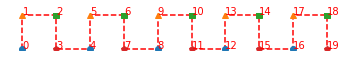

The couplings:


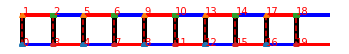

In [68]:
from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import SpinSite 

class KitaevLadderSnake(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        
        # totally 4 spins per site
        sites = _parse_sites(sites, 4)
        
        # basis for plotting
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 1.], [1., 0.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
        NNy = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        nNNa = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        nNNb = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
        kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)
        
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderSnakeModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        # conserve = get_parameter(model_params, 'conserve', None, self.name)
        conserve = model_params.get('conserve', None)
        S = model_params.get('S', .5)
        fs = SpinSite(conserve=conserve, S=S)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        
        L = model_params.get('L', 3)

        gs = self.init_sites(model_params)
        model_params.pop("L")


        order = model_params.get('order', 'default')
        bc = model_params.get('bc', 'open')
        bc_MPS=model_params.get('bc_MPS', 'finite')
        lattice_params = dict(
            order=order,
            bc=bc,
            bc_MPS=bc_MPS,
            basis=None,
            positions=None,
            nearest_neighbors=None,
            next_nearest_neighbors=None,
            next_next_nearest_neighbors=None,
            pairs={},
        )

        lat = KitaevLadderSnake(L, gs, **lattice_params)
        return lat

    def init_terms(self, model_params):
        
        Jx = model_params.get('Jx', 1.)
        Jy = model_params.get('Jy', 1.)
        Jz = model_params.get('Jz', 1.)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)

def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadderSnake(5, None, bc='periodic')
    print('The snake connection:')
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()
    print("The couplings:")
    
    fig, ax = plt.subplots()
    lat = KitaevLadderSnake(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5., color='black')
    links_name = 'nearest_neighbors_x'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5., color='red')
    links_name = 'nearest_neighbors_y'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5., color='blue')
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.show()
    
plot_lattice()

In [69]:
def run_atomic(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    S=.5,
    bc='periodic',
    bc_MPS='infinite',
    # dmrg parameters
    initial_psi=None, # input psi
    initial='random',
    max_E_err=1.e-6,
    max_S_err=1.e-4,
    max_sweeps=1000,
    N_sweeps_check=10,
    canonicalized=True,
    # control for the verbose output
    verbose=1, 
):
    """ 
        The fundamental function for running DMRG
    """

    #######################
    # set the paramters for model initialization
    model_params = dict(
        conserve=None, 
        Jx=Jx, 
        Jy=Jy, 
        Jz=Jz, 
        L=L, 
        S=S,
        verbose=verbose,
        bc=bc,
        bc_MPS=bc_MPS,
        )
    # initialize the model
    M = KitaevLadderSnakeModel(model_params)
    # providing a product state as the initial state
    # prod_state = ["up", "up"] * (2 * model_params['L'])
    # random generated initial state
    if initial_psi==None:
        prod_state = [ choice(["up", "down"]) for i in range(4 * L)]
        if initial == 'up':
            prod_state = ["up" for i in range(4 * L)]
        if initial == 'down':
            prod_state = ["down" for i in range(4 * L)]
        psi = MPS.from_product_state(
            M.lat.mps_sites(), 
            prod_state, 
            bc=M.lat.bc_MPS,
        )
    else:
        psi = initial_psi.copy()
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-3,
            'decay': 1.2,
            'disable_after': 50
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,
        'N_sweeps_check': N_sweeps_check,
        'verbose': verbose,
    }
    #######################
    
    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()

    if canonicalized:
        psi.canonical_form()
        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()


        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        
    # the wave function, the ground-state energy, and the DMRG engine are all that we need
    result = dict(
        psi=psi.copy(),
        energy=energy,
        sweeps_stat=eng.sweep_stats.copy(),
        parameters=dict(
            # model parameters
            chi=chi,
            Jx=Jx, 
            Jy=Jy, 
            Jz=Jz, 
            L=L, 
            # dmrg parameters
            initial_psi=initial_psi,
            initial=initial,
            max_E_err=max_E_err,
            max_S_err=max_S_err,
            max_sweeps=max_sweeps,
        )
    )
    return result

def naming(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    max_S_err=1.e-4,
    ):
    return "KitaevLadderSnake"+"_chi_"+str(chi)+"_Jx_"+str(Jx)+"_Jy_"+str(Jy)+"_Jz_"+str(Jz)+"_L_"+str(L)+"_maxSerr_"+str(max_S_err)

def full_path(
    # model parameters
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    max_S_err=1.e-4,
    prefix='data/', suffix='.h5',
    **kwargs):
    return prefix+naming(chi, Jx, Jy, Jz, L, max_S_err)+suffix
    
def save_after_run(run, folder_prefix='data/'):
    """
        Save data as .h5 files
    """
    @wraps(run)
    def wrapper(*args, **kwargs):
        
        file_name = full_path(prefix=folder_prefix, **kwargs)
        
        # if the file already existed then don't do the computation again
        if os.path.isfile(file_name):
            print("This file already existed. Pass.")
            return 0
        else:
            result = run(*args, **kwargs)
            with h5py.File(file_name, 'w') as f:
                hdf5_io.save_to_hdf5(f, result)
                
            return result
    
    return wrapper

def load_data(
    chi=30,
    Jx=1., 
    Jy=1., 
    Jz=0., 
    L=3, 
    max_S_err=1.e-4,
    prefix='data/', 
):
    file_name = full_path(chi, Jx, Jy, Jz, L, max_S_err, prefix=prefix, suffix='.h5')
    if not Path(file_name).exists():
        return -1
    with h5py.File(file_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        return data
    
run_save = save_after_run(run_atomic)    

In [70]:
def finite_scaling(
    # model params, should be input
    Jx = 0.5,
    Jy = 0.5,
    Jz = 0,
    L = 3,

    # next there are some DMRG params
    # tolerance for entropy calc error, should be input
    max_S_err = 1e-4,
    N_sweeps_check = 5,
    max_sweeps = 1000,

    # bond dimension list, should be input
    chi_list = range(8, 50, 2),
    
    # initial wave function
    psi = None,

    verbose = 1,
    
    # should we load the existing files and also save the results into files
    save_and_load = False,
    
    # should we do plotting after calculation
    plot = False,
):
    """
        Computing the finite-scaling cases at a specific `J=(Jx, Jy, Jz)`, over a specific bond dimension region.
        Return `S_list, xi_list`
    """
    
    if save_and_load:
    # folder name
        prefix = f'data/'
        # if there is no such folder, create another one; if exists, doesn't matter
        Path(prefix).mkdir(parents=True, exist_ok=True)
        run_save = save_after_run(run_atomic, folder_prefix=prefix)


    S_list = []
    xi_list = []

    psi = psi
    
    for chi in chi_list:
        
        if save_and_load:
            data = run_save(
                Jx = Jx,
                Jy = Jy,
                Jz = Jz,
                L = L,
                max_S_err=max_S_err,
                chi = chi,
                initial_psi=psi,
                N_sweeps_check=N_sweeps_check,    
                max_sweeps=max_sweeps, 
                verbose=verbose,
            )

            if data==0:
                data = load_data(Jx = Jx, Jy = Jy, Jz = Jz, L = L, chi = chi, prefix = prefix)
                pass
            pass
        else:
            data = run_atomic(
                Jx = Jx,
                Jy = Jy,
                Jz = Jz,
                L = L,
                max_S_err=max_S_err,
                chi = chi,
                initial_psi=psi,
                N_sweeps_check=N_sweeps_check,    
                max_sweeps=max_sweeps, 
                verbose=verbose,
            )
            pass
        
        psi = data['psi']
        S_list.append(np.mean(psi.entanglement_entropy()))
        xi_list.append(psi.correlation_length())        
        pass
    
    if plot:
        start = 0
        end = -1

        xs = np.log(xi_list[start:end])
        ys = S_list[start:end]

        def func(log_xi, c, a):
            return (c / 6) * log_xi + a
        fitParams, fitCovariances = curve_fit(func, xs, ys)

        plt.plot(xs, ys, 'o', label='Data Points')
        plt.xlabel(r'Log of Correlation Length, $\log\xi$')
        plt.ylabel(r'Average Entanglement Entropy, $S$')

        fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
        plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

        plt.legend()
        title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
        plt.title(title_name)

        plt.show()
        
        plt.plot(chi_list[start:end], S_list[start:end])
        plt.xlabel(r'Max Bond Dimension $\chi$')
        plt.ylabel(r'Average Entanglement Entropy, $S$')
        plt.legend()
        title_name = f'EE at different BD at J = ({Jx}, {Jy}, {Jz}), L={L}'
        plt.title(title_name)
        plt.show()
#         plt.savefig(title_name + '.png')
        pass
    return S_list, xi_list

In [55]:
chi_list = [int(2**n) for n in np.arange(3, 9, 1)]
# chi_list = np.arange(30, 100, 4)
Jx = .5
Jy = .5
Jz = 0
L = 3

S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    L=L,
    chi_list=chi_list,
)

Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Confi

Updating environment
..
sweep 90, age = 3276
Energy = -0.0792901562832202, S = 0.7047467479222905, norm_err = 3.7e-05
Current memory usage 257.7 MB, time elapsed: 29.0 s
Delta E = -7.5850e-07, Delta S = 1.8499e-02 (per sweep)
max_trunc_err = 3.6841e-03, max_E_trunc = 1.0352e-03
MPS bond dimensions: [6, 8, 8, 5, 8, 8, 8, 8, 8, 4, 8, 8]
Updating environment
..
sweep 95, age = 3444
Energy = -0.0793450162629495, S = 0.6845254822386638, norm_err = 7.4e-06
Current memory usage 257.7 MB, time elapsed: 30.6 s
Delta E = -1.0972e-05, Delta S = -4.0443e-03 (per sweep)
max_trunc_err = 4.8177e-03, max_E_trunc = 2.1053e-03
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 7, 8, 4, 8, 8]
Updating environment
..
sweep 100, age = 3612
Energy = -0.0793486207987992, S = 0.6755144049591789, norm_err = 1.9e-05
Current memory usage 257.7 MB, time elapsed: 32.1 s
Delta E = -7.2091e-07, Delta S = -1.8022e-03 (per sweep)
max_trunc_err = 2.9311e-03, max_E_trunc = 1.3594e-03
MPS bond dimensions: [8, 5, 8, 7, 6, 7, 8, 8

Updating environment
..
sweep 190, age = 6636
Energy = -0.0793589015413829, S = 0.7289609292685121, norm_err = 2.0e-05
Current memory usage 257.7 MB, time elapsed: 60.0 s
Delta E = -1.3778e-05, Delta S = 1.0259e-02 (per sweep)
max_trunc_err = 4.6275e-03, max_E_trunc = 2.0427e-03
MPS bond dimensions: [8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8]
Updating environment
..
sweep 195, age = 6804
Energy = -0.0793589083340531, S = 0.6819885495486351, norm_err = 3.7e-06
Current memory usage 257.7 MB, time elapsed: 61.6 s
Delta E = -1.3585e-09, Delta S = -9.3945e-03 (per sweep)
max_trunc_err = 3.3847e-04, max_E_trunc = 2.1689e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Updating environment
..
sweep 200, age = 6972
Energy = -0.0792487565427962, S = 0.7551477167451104, norm_err = 3.0e-05
Current memory usage 257.7 MB, time elapsed: 63.2 s
Delta E = 2.2030e-05, Delta S = 1.4632e-02 (per sweep)
max_trunc_err = 3.4538e-04, max_E_trunc = 2.2113e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 8

Updating environment
..
sweep 290, age = 9996
Energy = -0.0793571532329527, S = 0.6810021257414799, norm_err = 1.7e-05
Current memory usage 257.7 MB, time elapsed: 91.6 s
Delta E = -6.9437e-05, Delta S = -2.6001e-02 (per sweep)
max_trunc_err = 2.6204e-04, max_E_trunc = 1.7027e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8]
Updating environment
..
sweep 295, age = 10164
Energy = -0.0326590759965863, S = 1.0707395995638971, norm_err = 3.9e-04
Current memory usage 257.7 MB, time elapsed: 93.2 s
Delta E = 9.3396e-03, Delta S = 7.7947e-02 (per sweep)
max_trunc_err = 1.1714e-03, max_E_trunc = 4.5804e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 8, 5, 4, 8, 8]
Updating environment
..
sweep 300, age = 10332
Energy = -0.0792834627861462, S = 0.7500296016057698, norm_err = 2.7e-05
Current memory usage 257.7 MB, time elapsed: 94.7 s
Delta E = -9.3249e-03, Delta S = -6.4142e-02 (per sweep)
max_trunc_err = 3.7726e-03, max_E_trunc = 2.1310e-03
MPS bond dimensions: [8, 8, 8, 8, 8, 6, 8

Updating environment
..
sweep 390, age = 13356
Energy = -0.0792340338288019, S = 0.6825259857184482, norm_err = 2.8e-05
Current memory usage 257.7 MB, time elapsed: 125.0 s
Delta E = 1.0776e-05, Delta S = -9.9394e-03 (per sweep)
max_trunc_err = 9.0723e-03, max_E_trunc = 4.7221e-03
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 6, 8]
Updating environment
..
sweep 395, age = 13524
Energy = -0.0781661472721756, S = 0.6754796023026377, norm_err = 3.7e-05
Current memory usage 257.7 MB, time elapsed: 126.9 s
Delta E = 2.1358e-04, Delta S = -1.4093e-03 (per sweep)
max_trunc_err = 3.8391e-03, max_E_trunc = 1.4004e-03
MPS bond dimensions: [8, 7, 8, 8, 8, 8, 8, 8, 8, 4, 8, 4]
Updating environment
..
sweep 400, age = 13692
Energy = -0.0793581801187031, S = 0.7218144892984909, norm_err = 1.3e-05
Current memory usage 257.7 MB, time elapsed: 128.7 s
Delta E = -2.3841e-04, Delta S = 9.2670e-03 (per sweep)
max_trunc_err = 3.5159e-04, max_E_trunc = 2.2471e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 7

Updating environment
..
sweep 490, age = 16716
Energy = -0.0792916818127670, S = 0.7303924453196537, norm_err = 9.7e-06
Current memory usage 257.7 MB, time elapsed: 156.7 s
Delta E = 1.2750e-05, Delta S = -6.9957e-03 (per sweep)
max_trunc_err = 3.8424e-03, max_E_trunc = 1.8075e-03
MPS bond dimensions: [8, 8, 8, 4, 8, 6, 8, 8, 8, 8, 6, 8]
Updating environment
..
sweep 495, age = 16884
Energy = -0.0792913109653834, S = 0.7130137786873095, norm_err = 1.3e-05
Current memory usage 257.7 MB, time elapsed: 158.2 s
Delta E = 7.4169e-08, Delta S = -3.4757e-03 (per sweep)
max_trunc_err = 6.2922e-03, max_E_trunc = 3.0280e-03
MPS bond dimensions: [3, 4, 8, 8, 8, 5, 8, 8, 8, 8, 8, 6]
Updating environment
..
sweep 500, age = 17052
Energy = -0.0793602552539312, S = 0.7325593044339104, norm_err = 4.9e-06
Current memory usage 257.7 MB, time elapsed: 159.8 s
Delta E = -1.3789e-05, Delta S = 3.9091e-03 (per sweep)
max_trunc_err = 3.1790e-04, max_E_trunc = 2.0437e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 4

Updating environment
..
sweep 590, age = 20076
Energy = -0.0793593952646650, S = 0.7526206603740797, norm_err = 3.9e-06
Current memory usage 257.7 MB, time elapsed: 191.5 s
Delta E = -1.5989e-07, Delta S = -2.0564e-02 (per sweep)
max_trunc_err = 3.4168e-04, max_E_trunc = 2.1868e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Updating environment
..
sweep 595, age = 20244
Energy = -0.0792896349568271, S = 0.7073484306108563, norm_err = 9.9e-06
Current memory usage 257.7 MB, time elapsed: 193.3 s
Delta E = 1.3952e-05, Delta S = -9.0544e-03 (per sweep)
max_trunc_err = 6.5979e-03, max_E_trunc = 3.3156e-03
MPS bond dimensions: [8, 6, 8, 7, 8, 8, 8, 8, 6, 8, 8, 8]
Updating environment
..
sweep 600, age = 20412
Energy = -0.0792900290533112, S = 0.6786141158675537, norm_err = 4.6e-06
Current memory usage 257.7 MB, time elapsed: 194.9 s
Delta E = -7.8819e-08, Delta S = -5.7469e-03 (per sweep)
max_trunc_err = 3.9102e-03, max_E_trunc = 1.8141e-03
MPS bond dimensions: [8, 4, 8, 8, 8,

Updating environment
..
sweep 690, age = 23436
Energy = -0.0792392309428275, S = 0.7322917540010975, norm_err = 2.0e-06
Current memory usage 257.7 MB, time elapsed: 226.4 s
Delta E = -3.2389e-05, Delta S = -2.1098e-02 (per sweep)
max_trunc_err = 8.2862e-03, max_E_trunc = 4.3681e-03
MPS bond dimensions: [8, 6, 8, 6, 4, 4, 8, 6, 6, 8, 8, 8]
Updating environment
..
sweep 695, age = 23604
Energy = -0.0793598751127054, S = 0.8002097500454178, norm_err = 2.7e-05
Current memory usage 257.7 MB, time elapsed: 228.0 s
Delta E = -2.4129e-05, Delta S = 1.3584e-02 (per sweep)
max_trunc_err = 3.5016e-04, max_E_trunc = 2.2401e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 4, 8, 4, 8, 8, 8, 8]
Updating environment
..
sweep 700, age = 23772
Energy = -0.0793587721837052, S = 0.8168093662837114, norm_err = 8.8e-06
Current memory usage 257.7 MB, time elapsed: 229.6 s
Delta E = 2.2059e-07, Delta S = 3.3199e-03 (per sweep)
max_trunc_err = 3.5319e-04, max_E_trunc = 2.2566e-04
MPS bond dimensions: [8, 8, 8, 8, 8, 8

Updating environment
..
sweep 790, age = 26796
Energy = -0.0789342625065122, S = 0.6544616725383787, norm_err = 3.6e-05
Current memory usage 257.7 MB, time elapsed: 259.5 s
Delta E = 2.1199e-05, Delta S = 9.9301e-03 (per sweep)
max_trunc_err = 9.3518e-03, max_E_trunc = 4.8402e-03
MPS bond dimensions: [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 7]
Updating environment
..
sweep 795, age = 26964
Energy = -0.0792917967716752, S = 0.7794525063500579, norm_err = 1.6e-05
Current memory usage 257.7 MB, time elapsed: 261.3 s
Delta E = -7.1507e-05, Delta S = 2.4998e-02 (per sweep)
max_trunc_err = 4.9509e-03, max_E_trunc = 2.1245e-03
MPS bond dimensions: [8, 4, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8]
Updating environment
..
sweep 800, age = 27132
Energy = -0.0790010355627639, S = 0.8040042414057206, norm_err = 8.3e-06
Current memory usage 257.7 MB, time elapsed: 263.0 s
Delta E = 5.8152e-05, Delta S = 4.9103e-03 (per sweep)
max_trunc_err = 3.9737e-03, max_E_trunc = 2.1596e-03
MPS bond dimensions: [8, 8, 8, 8, 6, 8, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Before the canonicalization:
Bond dim =  [6, 8, 8, 8, 8, 4, 8, 8, 8, 6, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996-1.877486560719351e-17j)
After the canonicalization:
Bond dim =  [6, 8, 8, 8, 8, 4, 8, 8, 8, 6, 8, 8]
Computing properties
Optimizing
Loop for chi=8 done.
============================== END ==============================


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
DMRG finished after 25 sweeps.
total size = 1140, maximum chi = 16
Before the canonicalization:
Bond dim =  [16, 16, 15, 16, 16, 16, 15, 16, 16, 16, 16, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999991-1.5752764733082094e-16j)
After the canonicalization:
Bond dim =  [16, 16, 15, 16, 16, 16, 15, 16, 16, 16, 16, 16]
Computing properties
Optimizing
Loop for chi=16 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  32 

Subconfig 'trunc_params'=Co

Updating environment
..
sweep 10, age = 588
Energy = -0.0795749775335288, S = nan, norm_err = 3.1e-03
Current memory usage 257.7 MB, time elapsed: 16.2 s
Delta E = -1.4183e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7472e-07, max_E_trunc = 2.1457e-07
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 15, age = 756
Energy = -0.0795661900628242, S = nan, norm_err = 2.1e-03
Current memory usage 257.7 MB, time elapsed: 22.3 s
Delta E = 1.7575e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8690e-07, max_E_trunc = 4.3778e-07
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
..
sweep 20, age = 924
Energy = -0.0795768920944979, S = 1.1005641959547177, norm_err = 1.7e-03
Current memory usage 257.7 MB, time elapsed: 26.8 s
Delta E = -2.1404e-06, Delta S = nan (per sweep)
max_trunc_err = 6.2580e-07, max_E_trunc 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
DMRG finished after 85 sweeps.
total size = 3252, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000029+2.32826415345918e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0 for config KitaevLadderSnakeModel


==============================START=======================

Updating environment
..
sweep 75, age = 2772
Energy = -0.0795773810683009, S = 1.3716409841162231, norm_err = 1.8e-04
Current memory usage 260.1 MB, time elapsed: 134.6 s
Delta E = -1.3775e-10, Delta S = 8.5223e-04 (per sweep)
max_trunc_err = 1.2027e-07, max_E_trunc = 1.0991e-07
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 127, 128, 128, 128, 128, 128]
Updating environment
..
sweep 80, age = 2940
Energy = -0.0795773815274892, S = 1.3751770112594530, norm_err = 1.5e-04
Current memory usage 260.1 MB, time elapsed: 141.2 s
Delta E = -9.1838e-11, Delta S = 7.0721e-04 (per sweep)
max_trunc_err = 1.2388e-07, max_E_trunc = 1.1308e-07
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 127, 128, 128, 128, 128, 128]
Updating environment
..
sweep 85, age = 3108
Energy = -0.0795773819067378, S = 1.3781469804087385, norm_err = 1.2e-04
Current memory usage 260.1 MB, time elapsed: 147.8 s
Delta E = -7.5850e-11, Delta S = 5.9399e-04 (per sweep)
max_trunc_err = 1.2724e-07, max_E_trunc = 1.1600e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.29e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 140 sweeps.
total size = 5196, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 127, 128, 124, 128, 128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004-2.757312553563119e-16j)
After the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 127, 128, 124, 128, 128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  256 

Sub

Updating environment
..
sweep 75, age = 2772
Energy = -0.0795774457931723, S = 1.3684945047187458, norm_err = 3.1e-04
Current memory usage 486.0 MB, time elapsed: 829.1 s
Delta E = -5.1934e-10, Delta S = 1.9970e-03 (per sweep)
max_trunc_err = 1.1603e-08, max_E_trunc = 1.0877e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Updating environment
..
sweep 80, age = 2940
Energy = -0.0795774478613100, S = 1.3776389204569002, norm_err = 2.7e-04
Current memory usage 486.0 MB, time elapsed: 865.6 s
Delta E = -4.1363e-10, Delta S = 1.8289e-03 (per sweep)
max_trunc_err = 1.2868e-08, max_E_trunc = 1.2023e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Updating environment
..
sweep 85, age = 3108
Energy = -0.0795774495211745, S = 1.3860889943716812, norm_err = 2.6e-04
Current memory usage 486.0 MB, time elapsed: 902.2 s
Delta E = -3.3197e-10, Delta S = 1.6900e-03 (per sweep)
max_trunc_err = 1.4051e-08, max_E_trunc = 1.3105e

Updating environment
..
sweep 170, age = 5964
Energy = -0.0795774571707852, S = 1.4611355720252319, norm_err = 1.1e-04
Current memory usage 486.0 MB, time elapsed: 1524.2 s
Delta E = -1.3604e-11, Delta S = 4.5141e-04 (per sweep)
max_trunc_err = 2.7104e-08, max_E_trunc = 2.4671e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Updating environment
..
sweep 175, age = 6132
Energy = -0.0795774569801182, S = 1.4637004679564394, norm_err = 1.1e-04
Current memory usage 486.0 MB, time elapsed: 1563.5 s
Delta E = 3.8133e-11, Delta S = 5.1298e-04 (per sweep)
max_trunc_err = 2.7564e-08, max_E_trunc = 2.5080e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Updating environment
..
sweep 180, age = 6300
Energy = -0.0795774573023256, S = 1.4652542994393827, norm_err = 1.1e-04
Current memory usage 486.0 MB, time elapsed: 1600.6 s
Delta E = -6.4441e-11, Delta S = 3.1077e-04 (per sweep)
max_trunc_err = 2.7995e-08, max_E_trunc = 2.

Updating environment
..
sweep 265, age = 9156
Energy = -0.0795774576422256, S = 1.4843911014493711, norm_err = 3.1e-05
Current memory usage 486.0 MB, time elapsed: 2226.4 s
Delta E = 2.1563e-12, Delta S = 1.3015e-04 (per sweep)
max_trunc_err = 3.2227e-08, max_E_trunc = 2.9242e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Updating environment
..
sweep 270, age = 9324
Energy = -0.0795774576645461, S = 1.4848498461392479, norm_err = 3.1e-05
Current memory usage 486.0 MB, time elapsed: 2263.7 s
Delta E = -4.4641e-12, Delta S = 9.1749e-05 (per sweep)
max_trunc_err = 3.2341e-08, max_E_trunc = 2.9346e-08
MPS bond dimensions: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
norm_tol=1.00e-05 not reached, norm_err=3.11e-05
Updating environment


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.49e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


DMRG finished after 270 sweeps.
total size = 9564, maximum chi = 256
Before the canonicalization:
Bond dim =  [251, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993-3.469336109751532e-16j)
After the canonicalization:
Bond dim =  [251, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Computing properties
Optimizing
Loop for chi=256 done.
============================== END ==============================


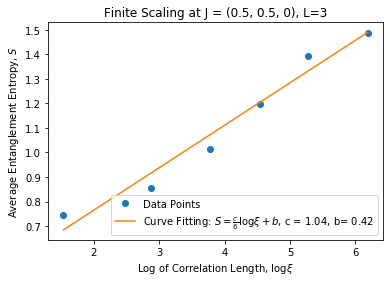

In [56]:
start = 0
end = -1

xs = np.log(xi_list[start:])
ys = S_list[start:]

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, xs, ys)

plt.plot(xs, ys, 'o', label='Data Points')
plt.xlabel(r'Log of Correlation Length, $\log\xi$')
plt.ylabel(r'Average Entanglement Entropy, $S$')

fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

plt.legend()
title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
plt.title(title_name)

plt.show()

In [15]:
chi_list = [int(2**n) for n in np.arange(3, 8, .5)]
Jx = 1.
Jy = 1.
Jz = 3.
L = 3

S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    L=L,
    chi_list=chi_list,
)

Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeModel
Reading 'Jz'=3.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Before the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999964+3.337038629289924e-16j)
After the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Computing properties
Optimizing
Loop for chi=8 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeModel
Reading 'Jz'=3.0 for config KitaevLadderSnakeModel


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  11 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
..
sweep 5, age = 420
Energy = -0.4085573106958111, S = nan, norm_err = 9.9e-04
Current memory usage 232.9 MB, time elapsed: 5.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2077e-06, max_E_trunc = 2.0557e-06
MPS bond dimensions: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Updating environment
..
sweep 10, age = 588

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Before the canonicalization:
Bond dim =  [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999898-5.919749155726775e-17j)
After the canonicalization:
Bond dim =  [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Computing properties
Optimizing
Loop for chi=11 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeModel
Reading 'Jz'=3.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
DMRG finished after 35 sweeps.
total size = 1476, maximum chi = 16
Before the canonicalization:
Bond dim =  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000007+8.118641392843018e-16j)
After the canonicalization:
Bond dim =  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Computing properties
Optimizing
Loop for chi=16 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeModel
Reading 'Jz'=3.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  22 

Subconfig 'trunc_params'=Co

..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
..
sweep 5, age = 420
Energy = -0.4085590884561157, S = nan, norm_err = 4.5e-03
Current memory usage 232.9 MB, time elapsed: 7.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8242e-09, max_E_trunc = 2.9308e-09
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Updating environment
..
sweep 10, age = 588
Energy = -0.4085594980489494, S = nan, norm_err = 2.5e-03
Current memory usage 232.9 MB, time elapsed: 13.0 s
Delta E = -8.1919e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1119e-09, max_E_trunc = 1.0957e-08
MPS bond dimensions: [32, 32, 32, 32, 32,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.36e-05
Call psi.canonical_form()
DMRG finished after 85 sweeps.
total size = 3348, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1+1.3617579286417936e-16j)
After the canonicalization:
Bond dim =  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeModel
Reading '

Updating environment
..
sweep 75, age = 2772
Energy = -0.4085596633834901, S = 0.6887861812614072, norm_err = 1.9e-04
Current memory usage 232.9 MB, time elapsed: 46.6 s
Delta E = -4.6613e-11, Delta S = 6.0878e-04 (per sweep)
max_trunc_err = 4.4557e-09, max_E_trunc = 1.7032e-08
MPS bond dimensions: [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Updating environment
..
sweep 80, age = 2940
Energy = -0.4085596635536604, S = 0.6912925292057103, norm_err = 1.6e-04
Current memory usage 232.9 MB, time elapsed: 48.9 s
Delta E = -3.4034e-11, Delta S = 5.0127e-04 (per sweep)
max_trunc_err = 4.5753e-09, max_E_trunc = 1.7447e-08
MPS bond dimensions: [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Updating environment
..
sweep 85, age = 3108
Energy = -0.4085596636811791, S = 0.6935698741155686, norm_err = 1.5e-04
Current memory usage 232.9 MB, time elapsed: 51.0 s
Delta E = -2.5504e-11, Delta S = 4.5547e-04 (per sweep)
max_trunc_err = 4.6801e-09, max_E_trunc = 1.7810e-08
MPS bond dimensions: [4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.73e-05
Call psi.canonical_form()
DMRG finished after 145 sweeps.
total size = 5364, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.00000000000001+5.48172618408671e-16j)
After the canonicalization:
Bond dim =  [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeM

Updating environment
..
sweep 75, age = 2772
Energy = -0.4085596711664626, S = 0.7058635588462843, norm_err = 2.3e-04
Current memory usage 232.9 MB, time elapsed: 86.2 s
Delta E = -8.3342e-11, Delta S = 9.9649e-04 (per sweep)
max_trunc_err = 7.0839e-10, max_E_trunc = 2.5116e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 80, age = 2940
Energy = -0.4085596714931986, S = 0.7104268348815866, norm_err = 3.0e-04
Current memory usage 232.9 MB, time elapsed: 89.6 s
Delta E = -6.5347e-11, Delta S = 9.1266e-04 (per sweep)
max_trunc_err = 7.6450e-10, max_E_trunc = 2.6782e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 85, age = 3108
Energy = -0.4085596717461802, S = 0.7138144729469551, norm_err = 2.3e-04
Current memory usage 232.9 MB, time elapsed: 92.6 s
Delta E = -5.0596e-11, Delta S = 6.7753e-04 (per sweep)
max_trunc_err = 8.1060e-10, max_E_trunc = 2.8267e-09
MPS bond dimensions: [6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.18e-04
Call psi.canonical_form()
DMRG finished after 145 sweeps.
total size = 5364, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000149+2.3744027577432547e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderS

Updating environment
..
sweep 75, age = 2772
Energy = -0.4085596727312766, S = 0.7119968728004736, norm_err = 3.1e-04
Current memory usage 232.9 MB, time elapsed: 131.2 s
Delta E = -9.7051e-11, Delta S = 1.0871e-03 (per sweep)
max_trunc_err = 1.0855e-10, max_E_trunc = 4.0768e-10
MPS bond dimensions: [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Updating environment
..
sweep 80, age = 2940
Energy = -0.4085596731248226, S = 0.7169766929389464, norm_err = 2.9e-04
Current memory usage 232.9 MB, time elapsed: 139.3 s
Delta E = -7.8709e-11, Delta S = 9.9596e-04 (per sweep)
max_trunc_err = 1.1860e-10, max_E_trunc = 4.4270e-10
MPS bond dimensions: [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Updating environment
..
sweep 85, age = 3108
Energy = -0.4085596734510564, S = 0.7217850543118162, norm_err = 2.9e-04
Current memory usage 232.9 MB, time elapsed: 147.6 s
Delta E = -6.5247e-11, Delta S = 9.6167e-04 (per sweep)
max_trunc_err = 1.2834e-10, max_E_trunc = 4.7316e-10
MPS bond dimensions:

Updating environment
..
sweep 170, age = 5964
Energy = -0.4085596751454735, S = 0.7718810658408192, norm_err = 3.3e-04
Current memory usage 232.9 MB, time elapsed: 262.5 s
Delta E = 9.7771e-13, Delta S = 3.6928e-04 (per sweep)
max_trunc_err = 2.5741e-10, max_E_trunc = 1.0491e-09
MPS bond dimensions: [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Updating environment
..
sweep 175, age = 6132
Energy = -0.4085596751112917, S = 0.7745766829712483, norm_err = 4.0e-04
Current memory usage 232.9 MB, time elapsed: 269.0 s
Delta E = 6.8364e-12, Delta S = 5.3912e-04 (per sweep)
max_trunc_err = 2.6182e-10, max_E_trunc = 1.0750e-09
MPS bond dimensions: [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Updating environment
..
sweep 180, age = 6300
Energy = -0.4085596752095550, S = 0.7750570520848431, norm_err = 2.0e-04
Current memory usage 232.9 MB, time elapsed: 277.3 s
Delta E = -1.9653e-11, Delta S = 9.6074e-05 (per sweep)
max_trunc_err = 2.6884e-10, max_E_trunc = 1.1009e-09
MPS bond dimensions

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.73e-04
Call psi.canonical_form()
DMRG finished after 180 sweeps.
total size = 6540, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000093-3.546967407286328e-16j)
After the canonicalization:
Bond dim =  [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0 for config KitaevLadderSn

Updating environment
..
sweep 75, age = 2772
Energy = -0.4085596721876452, S = 0.7047282322312854, norm_err = 4.0e-04
Current memory usage 248.1 MB, time elapsed: 299.3 s
Delta E = -1.3987e-10, Delta S = 1.2564e-03 (per sweep)
max_trunc_err = 7.0074e-12, max_E_trunc = 3.0695e-11
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 80, age = 2940
Energy = -0.4085596727465675, S = 0.7108229727208425, norm_err = 4.2e-04
Current memory usage 248.1 MB, time elapsed: 315.8 s
Delta E = -1.1178e-10, Delta S = 1.2189e-03 (per sweep)
max_trunc_err = 8.2427e-12, max_E_trunc = 3.5243e-11
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 85, age = 3108
Energy = -0.4085596731985485, S = 0.7161040490309786, norm_err = 3.3e-04
Current memory usage 248.1 MB, time elapsed: 332.6 s
Delta E = -9.0396e-11, Delta S = 1.0562e-03 (per sweep)
max_trunc_err = 9.3202e-12, max_E_trunc = 3.6152e

Updating environment
..
sweep 170, age = 5964
Energy = -0.4085596756286615, S = 0.7758887941512566, norm_err = 1.7e-04
Current memory usage 248.1 MB, time elapsed: 671.7 s
Delta E = -1.5856e-11, Delta S = 5.1100e-04 (per sweep)
max_trunc_err = 3.4275e-11, max_E_trunc = 1.3642e-10
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 175, age = 6132
Energy = -0.4085596756623507, S = 0.7782001738847250, norm_err = 1.4e-04
Current memory usage 248.1 MB, time elapsed: 686.2 s
Delta E = -6.7378e-12, Delta S = 4.6228e-04 (per sweep)
max_trunc_err = 3.6029e-11, max_E_trunc = 1.4415e-10
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 180, age = 6300
Energy = -0.4085596756943725, S = 0.7804200737631527, norm_err = 1.5e-04
Current memory usage 248.1 MB, time elapsed: 702.7 s
Delta E = -6.4044e-12, Delta S = 4.4398e-04 (per sweep)
max_trunc_err = 3.7056e-11, max_E_trunc = 1.52

Updating environment
..
sweep 265, age = 9156
Energy = -0.4085596759623324, S = 0.8092947235531116, norm_err = 2.0e-04
Current memory usage 248.1 MB, time elapsed: 977.2 s
Delta E = -1.3870e-12, Delta S = 2.9387e-04 (per sweep)
max_trunc_err = 5.7388e-11, max_E_trunc = 2.5148e-10
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 270, age = 9324
Energy = -0.4085596759345170, S = 0.8102283287359904, norm_err = 2.1e-04
Current memory usage 248.1 MB, time elapsed: 995.9 s
Delta E = 5.5631e-12, Delta S = 1.8672e-04 (per sweep)
max_trunc_err = 5.7712e-11, max_E_trunc = 2.4284e-10
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 275, age = 9492
Energy = -0.4085596759820381, S = 0.8118260166139445, norm_err = 1.5e-04
Current memory usage 248.1 MB, time elapsed: 1016.3 s
Delta E = -9.5042e-12, Delta S = 3.1954e-04 (per sweep)
max_trunc_err = 5.8804e-11, max_E_trunc = 2.51

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.44e-04
Call psi.canonical_form()
DMRG finished after 305 sweeps.
total size = 10740, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+1.171751497913709e-16j)
After the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1.0

Updating environment
..
sweep 75, age = 2772
Energy = -0.4085596524297349, S = 0.9780834580415476, norm_err = 3.1e-03
Current memory usage 323.9 MB, time elapsed: 903.0 s
Delta E = -2.0573e-10, Delta S = 6.0203e-03 (per sweep)
max_trunc_err = 1.1833e-11, max_E_trunc = 9.3223e-12
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 80, age = 2940
Energy = -0.4085596648291414, S = 0.9702671309400760, norm_err = 1.2e-03
Current memory usage 323.9 MB, time elapsed: 963.3 s
Delta E = -2.4799e-09, Delta S = -1.5633e-03 (per sweep)
max_trunc_err = 3.1611e-12, max_E_trunc = 6.1391e-12
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 85, age = 3108
Energy = -0.4085596693643272, S = 0.9858600384307913, norm_err = 9.3e-04
Current memory usage 323.9 MB, time elapsed: 1023.3 s
Delta E = -9.0704e-10, Delta S = 3.1186e-03 (per sweep)
max_trunc_err = 3.8446e-12, max_E_trunc = 1.205

Updating environment
..
sweep 170, age = 5964
Energy = -0.4085596753574994, S = 1.0596071585082336, norm_err = 1.2e-04
Current memory usage 323.9 MB, time elapsed: 1771.7 s
Delta E = -1.4408e-11, Delta S = 2.8594e-04 (per sweep)
max_trunc_err = 2.6089e-11, max_E_trunc = 9.5042e-11
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 175, age = 6132
Energy = -0.4085596754426699, S = 1.0633231761800983, norm_err = 2.9e-04
Current memory usage 323.9 MB, time elapsed: 1820.0 s
Delta E = -1.7034e-11, Delta S = 7.4320e-04 (per sweep)
max_trunc_err = 2.8453e-11, max_E_trunc = 1.1050e-10
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 180, age = 6300
Energy = -0.4085596754733463, S = 1.0664775313045822, norm_err = 3.0e-04
Current memory usage 323.9 MB, time elapsed: 1860.4 s
Delta E = -6.1353e-12, Delta S = 6.3087e-04 (per sweep)
max_trunc_err = 3.0228e-11, max_E_trunc = 1

Updating environment
..
sweep 265, age = 9156
Energy = -0.4085596758887580, S = 1.1007432667558024, norm_err = 3.7e-04
Current memory usage 323.9 MB, time elapsed: 2622.6 s
Delta E = -4.5475e-13, Delta S = 3.7196e-04 (per sweep)
max_trunc_err = 6.3370e-11, max_E_trunc = 2.4875e-10
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 270, age = 9324
Energy = -0.4085596758864464, S = 1.1028388877621735, norm_err = 4.2e-04
Current memory usage 323.9 MB, time elapsed: 2668.2 s
Delta E = 4.6232e-13, Delta S = 4.1912e-04 (per sweep)
max_trunc_err = 6.4524e-11, max_E_trunc = 2.7649e-10
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 275, age = 9492
Energy = -0.4085596759152850, S = 1.1048169635045013, norm_err = 3.6e-04
Current memory usage 323.9 MB, time elapsed: 2716.6 s
Delta E = -5.7677e-12, Delta S = 3.9562e-04 (per sweep)
max_trunc_err = 6.6111e-11, max_E_trunc = 2.

Updating environment
..
sweep 360, age = 12348
Energy = -0.4085596679927145, S = 1.1398135380143395, norm_err = 4.2e-03
Current memory usage 323.9 MB, time elapsed: 3667.6 s
Delta E = 8.6994e-10, Delta S = 1.2929e-03 (per sweep)
max_trunc_err = 7.0980e-11, max_E_trunc = 2.9740e-10
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 365, age = 12516
Energy = -0.4085596584983857, S = 1.1497856142334177, norm_err = 6.8e-03
Current memory usage 323.9 MB, time elapsed: 3730.1 s
Delta E = 1.8989e-09, Delta S = 1.9944e-03 (per sweep)
max_trunc_err = 6.1873e-11, max_E_trunc = 2.5193e-10
MPS bond dimensions: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Updating environment
..
sweep 370, age = 12684
Energy = -0.4085596407863553, S = 1.1611561198006799, norm_err = 1.1e-02
Current memory usage 323.9 MB, time elapsed: 3794.4 s
Delta E = 3.5424e-09, Delta S = 2.2741e-03 (per sweep)
max_trunc_err = 5.6341e-11, max_E_trunc = 2

KeyboardInterrupt: 

In [ ]:
start = 0
end = -1

xs = np.log(xi_list[start:end])
ys = S_list[start:end]

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, xs, ys)

plt.plot(xs, ys, 'o', label='Data Points')
plt.xlabel(r'Log of Correlation Length, $\log\xi$')
plt.ylabel(r'Average Entanglement Entropy, $S$')

fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

plt.legend()
title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
plt.title(title_name)

plt.show()

In [33]:
chi_list = [int(2**n) for n in np.arange(4, 8, 1)]
a = .75
b = .5
Jx, Jy, Jz = get_xyz(a, b, biased=False)
L = 3

S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    L=L,
    chi_list=chi_list,
)

Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.625 for config KitaevLadderSnakeModel
Reading 'Jy'=0.125 for config KitaevLadderSnakeModel
Reading 'Jz'=0.25 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_param

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [24, 23, 18, 23, 24, 23, 28, 23, 24, 23, 22, 23]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000104+3.1117297678355233e-16j)
After the canonicalization:
Bond dim =  [24, 23, 18, 23, 24, 23, 28, 23, 24, 23, 22, 23]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.625 for config KitaevLadderSnakeModel
Reading 'Jy'=0.125 for config KitaevLadderSnakeModel
Reading 'Jz'=0.25 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [24, 23, 28, 23, 24, 23, 27, 23, 24, 23, 27, 23]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999971+2.332490508722686e-18j)
After the canonicalization:
Bond dim =  [24, 23, 28, 23, 24, 23, 27, 23, 24, 23, 27, 23]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.625 for config KitaevLadderSnakeModel
Reading 'Jy'=0.125 for config KitaevLadderSnakeModel
Reading 'Jz'=0.25 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [24, 23, 25, 23, 24, 23, 24, 23, 24, 24, 24, 23]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000102-8.470611580799824e-17j)
After the canonicalization:
Bond dim =  [24, 23, 25, 23, 24, 23, 24, 23, 24, 24, 24, 23]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


[32, 64, 128]


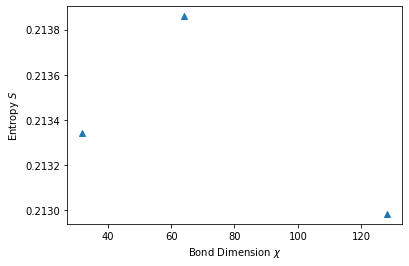

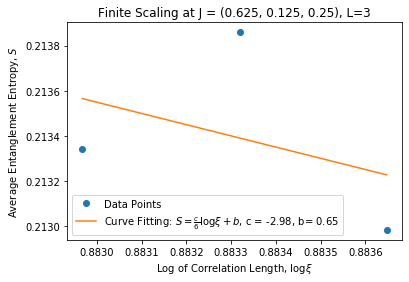

In [41]:
start = 1
# end = 

xs = np.log(xi_list[start:])
ys = S_list[start:]
chis = chi_list[start:]
print(chis)

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, xs, ys)

plt.plot((chis), ys, '^', label='Entropies')
plt.xlabel(r'Bond Dimension $\chi$')
plt.ylabel(r'Entropy $S$')
plt.show()

plt.plot(xs, ys, 'o', label='Data Points')
plt.xlabel(r'Log of Correlation Length, $\log\xi$')
plt.ylabel(r'Average Entanglement Entropy, $S$')

fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

plt.legend()
title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
plt.title(title_name)

plt.show()

## Phase Diagram

In [72]:
L = 2
max_S_err = 1e-4

a_list = np.linspace(-1, 1, 11)
b_list = np.linspace(0, 1, 6)
a_list = [np.round(a, decimals=decimals) for a in a_list]
b_list = [np.round(b, decimals=decimals) for b in b_list]
chi_list = [int(2**n) for n in np.arange(3, 7, .5)]

for a in a_list:
    for b in b_list:
        Jx, Jy, Jz = get_xyz(a, b, biased=False)
        initial_psi = None
        for chi in chi_list:
            data = run_save(
                Jx=Jx,
                Jy=Jy,
                Jz=Jz,
                L=L,
                max_S_err=max_S_err,
                chi=chi,
                initial_psi=initial_psi,
            )
            if data==0: # which means this file exists
                data = load_data(
                    Jx=Jx,
                    Jy=Jy,
                    Jz=Jz,
                    L=L,
                    max_S_err=max_S_err,
                    chi=chi,
                )
                pass
            
            psi = data['psi']
            initial_psi = psi.copy()

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=

KeyboardInterrupt: 

In [47]:
S_dict = {}
xi_dict = {}

for a in a_list:
    for b in b_list:
        Jx, Jy, Jz = get_xyz(a, b, biased=False)
        for chi in chi_list:
            data = load_data(
                Jx=Jx,
                Jy=Jy,
                Jz=Jz,
                L=L,
                max_S_err=max_S_err,
                chi=chi,
            )
            
            psi = data['psi']
            
            entropy_list = psi.entanglement_entropy()
            entropy = np.mean(entropy_list)
            S_dict[(a, b, chi)] = entropy
            
            correlation = psi.correlation_length()
            xi_dict[(a, b, chi)] = correlation

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2364: RuntimeWarning: divide by zero encountered in double_scalars
  return -1. / np.log(abs(E[1] / E[0])) * self.L
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming spe

In [71]:
chi1 = chi_list[2]
chi2 = chi_list[7]
A, B = np.meshgrid(a_list, b_list)
C1 = np.zeros_like(A)
C2 = np.zeros_like(A)
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        a = A[i, j]
        b = B[i, j]
        c = xi_dict[(a, b, chi1)]
        C1[i, j] = c
        C2[i, j] = xi_dict[(a, b, chi2)]
        
plt.imshow(C2-C1, extent=[a_list[0], a_list[-1], b_list[0], b_list[-1]], origin='lower',
           cmap='viridis')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"$dS$")
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

IndexError: list index out of range

Weird.

We got a different conclusion that the gapless line changed!

Jx=0.5, Jy=0.3, Jz=0.2


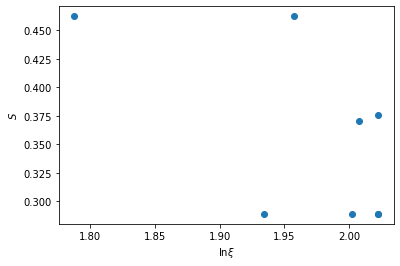

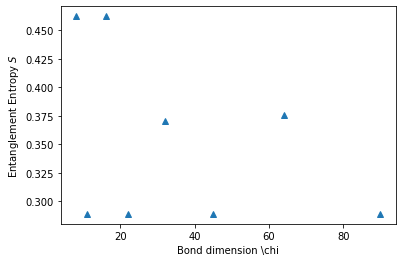

In [66]:
a = .8
b = .2
Jx, Jy, Jz = get_xyz(a, b, biased=False)
print(f'Jx={Jx}, Jy={Jy}, Jz={Jz}')
S_list = [S_dict[(a, b, chi)] for chi in chi_list]
xi_list = [xi_dict[(a, b, chi)] for chi in chi_list]
logxi_list = np.log(xi_list)

plt.plot(logxi_list, S_list, 'o')
plt.xlabel(r'$\ln \xi$')
plt.ylabel(r'$S$')
plt.show()

plt.plot(chi_list, S_list, '^')
plt.xlabel(r'Bond dimension \chi')
plt.ylabel(r'Entanglement Entropy $S$')
plt.show()

In [86]:
chi_list = [int(2**n) for n in np.arange(5, 8, .5)]
S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    chi_list=chi_list,
    L=5,
    save_and_load=False,
)

Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  32 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Co

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [32, 32, 32, 31, 32, 31, 32, 31, 32, 31, 32, 32, 32, 31, 32, 31, 32, 31, 32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000029-5.768916940017976e-16j)
After the canonicalization:
Bond dim =  [32, 32, 32, 31, 32, 31, 32, 31, 32, 31, 32, 32, 32, 31, 32, 31, 32, 31, 32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  45 

Subconfig 'trunc_params'=Config

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 35, 30, 36, 39, 36, 30, 35, 39, 35, 32, 34, 39, 34, 30, 35, 39, 33, 45, 34]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000078+7.21484867998014e-16j)
After the canonicalization:
Bond dim =  [38, 35, 30, 36, 39, 36, 30, 35, 39, 35, 32, 34, 39, 34, 30, 35, 39, 33, 45, 34]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================
Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 35, 45, 35, 38, 35, 33, 34, 38, 35, 32, 34, 38, 34, 34, 36, 37, 34, 31, 34]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000084+3.2439255661894853e-16j)
After the canonicalization:
Bond dim =  [38, 35, 45, 35, 38, 35, 33, 34, 38, 35, 32, 34, 38, 34, 34, 36, 37, 34, 31, 34]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  90 

Subconfig 'trunc_params'=Confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 35, 37, 34, 38, 34, 30, 35, 38, 34, 33, 34, 38, 34, 33, 35, 38, 35, 29, 34]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999997-3.709314254590011e-17j)
After the canonicalization:
Bond dim =  [38, 35, 37, 34, 38, 34, 30, 35, 38, 34, 33, 34, 38, 34, 33, 35, 38, 35, 29, 34]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================
Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 34, 45, 35, 38, 34, 32, 34, 38, 35, 31, 34, 38, 34, 29, 34, 38, 35, 36, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000115+8.148106416435738e-18j)
After the canonicalization:
Bond dim =  [38, 34, 45, 35, 38, 34, 32, 34, 38, 35, 31, 34, 38, 34, 29, 34, 38, 35, 36, 35]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=5 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  181 

Subconfig 'trunc_params'=Conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [37, 35, 29, 34, 38, 34, 28, 34, 38, 34, 30, 34, 37, 34, 31, 34, 37, 34, 31, 34]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000064+6.227877945537606e-17j)
After the canonicalization:
Bond dim =  [37, 35, 29, 34, 38, 34, 28, 34, 38, 34, 30, 34, 37, 34, 31, 34, 37, 34, 31, 34]
Computing properties
Optimizing
Loop for chi=181 done.
============================== END ==============================


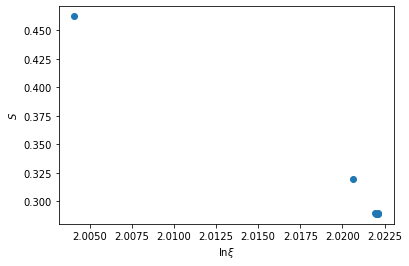

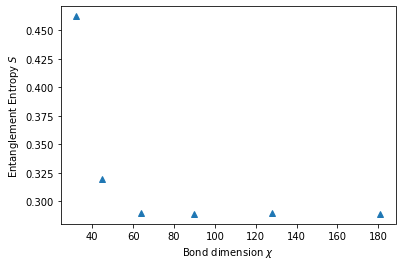

In [87]:
logxi_list = np.log(xi_list)

plt.plot(logxi_list, S_list, 'o')
plt.xlabel(r'$\ln \xi$')
plt.ylabel(r'$S$')
plt.show()

plt.plot(chi_list, S_list, '^')
plt.xlabel(r'Bond dimension $\chi$')
plt.ylabel(r'Entanglement Entropy $S$')
plt.show()

In [90]:
chi_list = [int(2**n) for n in np.linspace(3, 7, 10)]
Jx, Jy, Jz = get_xyz(.5, .5, biased=False)
S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    chi_list=chi_list,
    L=2,
    save_and_load=False,
)

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.01e-05
Call psi.canonical_form()
DMRG finished after 40 sweeps.
total size = 1224, maximum chi = 8
Before the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000084+0j)
After the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8]
Computing properties
Optimizing
Loop for chi=8 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLa

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
..
sweep 5, age = 280
Energy = -0.0795770140815146, S = nan, norm_err = 1.4e-03
Current memory usage 345.6 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7597e-08, max_E_trunc = 3.8108e-08
MPS bond dimensions: [10, 10, 10, 10, 10, 10, 10, 10]
Updating environment
..
sweep 10, age = 392
Energy = -0.0795771587137271, S = nan, norm_err = 1.2e-03
Current memory usage 345.6 MB, time elapsed: 4.1 s
Delta E = -2.8926e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0662e-07, max_E_trunc = 7.8678e-08
MPS bond dimensions: [10, 10, 10, 10, 10, 10, 10, 10]
Conver

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.36e-05
Call psi.canonical_form()
DMRG finished after 70 sweeps.
total size = 1896, maximum chi = 10
Before the canonicalization:
Bond dim =  [10, 10, 10, 10, 10, 10, 10, 10]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049+0j)
After the canonicalization:
Bond dim =  [10, 10, 10, 10, 10, 10, 10, 10]
Computing properties
Optimizing
Loop for chi=10 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 f

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774022243965, S = 0.5510702285870287, norm_err = 5.9e-05
Current memory usage 345.6 MB, time elapsed: 16.5 s
Delta E = -1.4346e-11, Delta S = 1.5682e-04 (per sweep)
max_trunc_err = 6.8043e-08, max_E_trunc = 4.8338e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774022730207, S = 0.5517100666838241, norm_err = 4.9e-05
Current memory usage 345.6 MB, time elapsed: 17.2 s
Delta E = -9.7248e-12, Delta S = 1.2797e-04 (per sweep)
max_trunc_err = 6.8664e-08, max_E_trunc = 4.8771e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774023060947, S = 0.5522325536847361, norm_err = 4.0e-05
Current memory usage 345.6 MB, time elapsed: 18.0 s
Delta E = -6.6148e-12, Delta S = 1.0450e-04 (per sweep)
max_trunc_err = 6.9174e-08, max_E_trunc = 4.9126e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
U

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.17e-05
Call psi.canonical_form()
DMRG finished after 95 sweeps.
total size = 2456, maximum chi = 14
Before the canonicalization:
Bond dim =  [14, 14, 14, 14, 14, 14, 14, 14]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000093+0j)
After the canonicalization:
Bond dim =  [14, 14, 14, 14, 14, 14, 14, 14]
Computing properties
Optimizing
Loop for chi=14 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 f

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774519502146, S = 0.5909248204810877, norm_err = 2.2e-04
Current memory usage 345.6 MB, time elapsed: 18.1 s
Delta E = -8.2379e-11, Delta S = 5.2461e-04 (per sweep)
max_trunc_err = 1.1409e-08, max_E_trunc = 9.2006e-09
MPS bond dimensions: [20, 20, 20, 20, 20, 20, 20, 20]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774522735151, S = 0.5933637140872678, norm_err = 2.1e-04
Current memory usage 345.6 MB, time elapsed: 18.9 s
Delta E = -6.4660e-11, Delta S = 4.8778e-04 (per sweep)
max_trunc_err = 1.1816e-08, max_E_trunc = 9.5274e-09
MPS bond dimensions: [20, 20, 20, 20, 20, 20, 20, 20]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774525301276, S = 0.5955050715450819, norm_err = 1.9e-04
Current memory usage 345.6 MB, time elapsed: 19.7 s
Delta E = -5.1323e-11, Delta S = 4.2827e-04 (per sweep)
max_trunc_err = 1.2189e-08, max_E_trunc = 9.8272e-09
MPS bond dimensions: [20, 20, 20, 20, 20, 20, 20, 20]
U

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.45e-05
Call psi.canonical_form()
DMRG finished after 150 sweeps.
total size = 3688, maximum chi = 20
Before the canonicalization:
Bond dim =  [20, 20, 20, 20, 20, 20, 20, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999938+0j)
After the canonicalization:
Bond dim =  [20, 20, 20, 20, 20, 20, 20, 20]
Computing properties
Optimizing
Loop for chi=20 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774627513595, S = 0.6085730779441820, norm_err = 2.9e-04
Current memory usage 345.6 MB, time elapsed: 24.6 s
Delta E = -1.0744e-10, Delta S = 6.4730e-04 (per sweep)
max_trunc_err = 2.2436e-09, max_E_trunc = 1.6810e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774632027975, S = 0.6119914221683025, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 25.7 s
Delta E = -9.0288e-11, Delta S = 6.8367e-04 (per sweep)
max_trunc_err = 2.3773e-09, max_E_trunc = 1.7803e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774635820869, S = 0.6147308962343286, norm_err = 2.0e-04
Current memory usage 345.6 MB, time elapsed: 26.8 s
Delta E = -7.5858e-11, Delta S = 5.4789e-04 (per sweep)
max_trunc_err = 2.4984e-09, max_E_trunc = 1.8696e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774658191739, S = 0.6459827405245059, norm_err = 5.7e-05
Current memory usage 345.6 MB, time elapsed: 47.2 s
Delta E = -6.4411e-12, Delta S = 1.7518e-04 (per sweep)
max_trunc_err = 3.9897e-09, max_E_trunc = 2.9552e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774658479758, S = 0.6470097416555453, norm_err = 9.4e-05
Current memory usage 345.6 MB, time elapsed: 48.3 s
Delta E = -5.7604e-12, Delta S = 2.0540e-04 (per sweep)
max_trunc_err = 4.0400e-09, max_E_trunc = 2.9926e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774658739390, S = 0.6478990720037463, norm_err = 5.4e-05
Current memory usage 345.6 MB, time elapsed: 49.4 s
Delta E = -5.1926e-12, Delta S = 1.7787e-04 (per sweep)
max_trunc_err = 4.0915e-09, max_E_trunc = 3.0295e-09
MPS bond dimensions: [27, 27, 27, 27, 27, 27, 27, 27

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.23e-05
Call psi.canonical_form()
DMRG finished after 245 sweeps.
total size = 5816, maximum chi = 27
Before the canonicalization:
Bond dim =  [27, 27, 27, 27, 27, 27, 27, 27]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000002+0j)
After the canonicalization:
Bond dim =  [27, 27, 27, 27, 27, 27, 27, 27]
Computing properties
Optimizing
Loop for chi=27 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774655167261, S = 0.6180460478521225, norm_err = 2.8e-04
Current memory usage 345.6 MB, time elapsed: 38.5 s
Delta E = -1.0741e-10, Delta S = 7.5027e-04 (per sweep)
max_trunc_err = 3.0134e-10, max_E_trunc = 1.7081e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774659820125, S = 0.6216108787765271, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 40.8 s
Delta E = -9.3057e-11, Delta S = 7.1297e-04 (per sweep)
max_trunc_err = 3.2001e-10, max_E_trunc = 1.8275e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774663874003, S = 0.6250036280383851, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 43.0 s
Delta E = -8.1078e-11, Delta S = 6.7855e-04 (per sweep)
max_trunc_err = 3.3805e-10, max_E_trunc = 1.9412e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774692633948, S = 0.6666642899144031, norm_err = 1.2e-04
Current memory usage 345.6 MB, time elapsed: 83.0 s
Delta E = -1.2100e-11, Delta S = 3.2782e-04 (per sweep)
max_trunc_err = 5.5468e-10, max_E_trunc = 4.2292e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774693188704, S = 0.6682473126994846, norm_err = 1.2e-04
Current memory usage 345.6 MB, time elapsed: 85.2 s
Delta E = -1.1095e-11, Delta S = 3.1660e-04 (per sweep)
max_trunc_err = 5.6149e-10, max_E_trunc = 4.3406e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774693698732, S = 0.6697767546880065, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 87.4 s
Delta E = -1.0201e-11, Delta S = 3.0589e-04 (per sweep)
max_trunc_err = 5.7552e-10, max_E_trunc = 4.4503e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774698400962, S = 0.6902566541447495, norm_err = 6.5e-05
Current memory usage 345.6 MB, time elapsed: 119.0 s
Delta E = -2.6247e-12, Delta S = 1.7209e-04 (per sweep)
max_trunc_err = 7.8203e-10, max_E_trunc = 6.0572e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774698520333, S = 0.6910915530842748, norm_err = 6.3e-05
Current memory usage 345.6 MB, time elapsed: 120.6 s
Delta E = -2.3874e-12, Delta S = 1.6698e-04 (per sweep)
max_trunc_err = 7.9118e-10, max_E_trunc = 6.1380e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37, 37]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774698636933, S = 0.6919017614548754, norm_err = 6.1e-05
Current memory usage 345.6 MB, time elapsed: 122.2 s
Delta E = -2.3320e-12, Delta S = 1.6204e-04 (per sweep)
max_trunc_err = 8.0010e-10, max_E_trunc = 6.2107e-10
MPS bond dimensions: [37, 37, 37, 37, 37, 37, 37,

norm_tol=1.00e-05 not reached, norm_err=3.78e-05
Updating environment
..
Updating environment


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.52e-05
Call psi.canonical_form()
DMRG finished after 375 sweeps.
total size = 8728, maximum chi = 37
Before the canonicalization:
Bond dim =  [37, 37, 37, 37, 37, 37, 37, 37]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000069+0j)
After the canonicalization:
Bond dim =  [37, 37, 37, 37, 37, 37, 37, 37]
Computing properties
Optimizing
Loop for chi=37 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774666308091, S = 0.6253741936541475, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 32.9 s
Delta E = -8.7173e-11, Delta S = 7.1087e-04 (per sweep)
max_trunc_err = 3.0294e-11, max_E_trunc = 2.5295e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774670149605, S = 0.6287601145293993, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 34.3 s
Delta E = -7.6830e-11, Delta S = 6.7718e-04 (per sweep)
max_trunc_err = 3.3390e-11, max_E_trunc = 2.7882e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774673544081, S = 0.6320497031333077, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 35.8 s
Delta E = -6.7890e-11, Delta S = 6.5792e-04 (per sweep)
max_trunc_err = 3.6615e-11, max_E_trunc = 3.0724e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774699974992, S = 0.6752349963982418, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 60.9 s
Delta E = -1.2813e-11, Delta S = 3.5852e-04 (per sweep)
max_trunc_err = 8.9360e-11, max_E_trunc = 7.2362e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774700569503, S = 0.6770298129833094, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 62.2 s
Delta E = -1.1890e-11, Delta S = 3.5896e-04 (per sweep)
max_trunc_err = 9.2354e-11, max_E_trunc = 7.5147e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774701123690, S = 0.6787807102249233, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 63.5 s
Delta E = -1.1084e-11, Delta S = 3.5018e-04 (per sweep)
max_trunc_err = 9.5334e-11, max_E_trunc = 7.7364e-11
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774706852974, S = 0.7038630826882263, norm_err = 7.0e-05
Current memory usage 345.6 MB, time elapsed: 88.9 s
Delta E = -3.8490e-12, Delta S = 1.9828e-04 (per sweep)
max_trunc_err = 1.4819e-10, max_E_trunc = 1.2062e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774707029295, S = 0.7049740087418332, norm_err = 9.0e-05
Current memory usage 345.6 MB, time elapsed: 90.2 s
Delta E = -3.5264e-12, Delta S = 2.2219e-04 (per sweep)
max_trunc_err = 1.5089e-10, max_E_trunc = 1.2244e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774707196131, S = 0.7062098499203857, norm_err = 9.7e-05
Current memory usage 345.6 MB, time elapsed: 91.5 s
Delta E = -3.3367e-12, Delta S = 2.4717e-04 (per sweep)
max_trunc_err = 1.5349e-10, max_E_trunc = 1.2506e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774709143728, S = 0.7227971241740818, norm_err = 6.7e-05
Current memory usage 345.6 MB, time elapsed: 115.3 s
Delta E = -1.3529e-12, Delta S = 1.7368e-04 (per sweep)
max_trunc_err = 1.9813e-10, max_E_trunc = 1.6064e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774709212793, S = 0.7235874360732115, norm_err = 5.5e-05
Current memory usage 345.6 MB, time elapsed: 116.6 s
Delta E = -1.3813e-12, Delta S = 1.5806e-04 (per sweep)
max_trunc_err = 2.0047e-10, max_E_trunc = 1.6212e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774709277808, S = 0.7242890645137094, norm_err = 4.9e-05
Current memory usage 345.6 MB, time elapsed: 117.8 s
Delta E = -1.3003e-12, Delta S = 1.4033e-04 (per sweep)
max_trunc_err = 2.0263e-10, max_E_trunc = 1.6553e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50,

Updating environment
..
sweep 480, age = 10920
Energy = -0.0795774710088182, S = 0.7359078782814593, norm_err = 4.6e-05
Current memory usage 345.6 MB, time elapsed: 141.4 s
Delta E = -6.1533e-13, Delta S = 1.1753e-04 (per sweep)
max_trunc_err = 2.3860e-10, max_E_trunc = 1.9327e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 485, age = 11032
Energy = -0.0795774710117314, S = 0.7364802273093353, norm_err = 4.3e-05
Current memory usage 345.6 MB, time elapsed: 142.6 s
Delta E = -5.8265e-13, Delta S = 1.1447e-04 (per sweep)
max_trunc_err = 2.4039e-10, max_E_trunc = 1.9520e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 50, 50]
Updating environment
..
sweep 490, age = 11144
Energy = -0.0795774710146162, S = 0.7370474648827730, norm_err = 4.0e-05
Current memory usage 345.6 MB, time elapsed: 143.9 s
Delta E = -5.7696e-13, Delta S = 1.1345e-04 (per sweep)
max_trunc_err = 2.4222e-10, max_E_trunc = 1.9600e-10
MPS bond dimensions: [50, 50, 50, 50, 50, 50, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.32e-05
Call psi.canonical_form()
DMRG finished after 495 sweeps.
total size = 11416, maximum chi = 50
Before the canonicalization:
Bond dim =  [50, 50, 50, 50, 50, 50, 50, 50]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999958+0j)
After the canonicalization:
Bond dim =  [50, 50, 50, 50, 50, 50, 50, 50]
Computing properties
Optimizing
Loop for chi=50 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnake

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774671569642, S = 0.6297703553340717, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 41.5 s
Delta E = -7.4674e-11, Delta S = 6.8426e-04 (per sweep)
max_trunc_err = 2.4001e-12, max_E_trunc = 2.5295e-12
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774674885674, S = 0.6330676914400337, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 43.2 s
Delta E = -6.6321e-11, Delta S = 6.5947e-04 (per sweep)
max_trunc_err = 2.7249e-12, max_E_trunc = 2.3874e-12
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774677843930, S = 0.6362373299708031, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 45.0 s
Delta E = -5.9165e-11, Delta S = 6.3393e-04 (per sweep)
max_trunc_err = 3.0824e-12, max_E_trunc = 3.0127e-12
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774701899177, S = 0.6791373417002283, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 75.2 s
Delta E = -1.2254e-11, Delta S = 3.8323e-04 (per sweep)
max_trunc_err = 1.1278e-11, max_E_trunc = 1.0743e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774702473118, S = 0.6809503053399597, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 77.0 s
Delta E = -1.1479e-11, Delta S = 3.6259e-04 (per sweep)
max_trunc_err = 1.1784e-11, max_E_trunc = 1.0857e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774703001371, S = 0.6828134892402264, norm_err = 1.6e-04
Current memory usage 345.6 MB, time elapsed: 78.9 s
Delta E = -1.0565e-11, Delta S = 3.7264e-04 (per sweep)
max_trunc_err = 1.2439e-11, max_E_trunc = 1.0857e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774708764796, S = 0.7094120088533269, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 107.9 s
Delta E = -3.9279e-12, Delta S = 2.4670e-04 (per sweep)
max_trunc_err = 2.0704e-11, max_E_trunc = 1.8076e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774708938382, S = 0.7106749589506069, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 109.8 s
Delta E = -3.4717e-12, Delta S = 2.5259e-04 (per sweep)
max_trunc_err = 2.1459e-11, max_E_trunc = 1.8758e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774709131507, S = 0.7117454333374034, norm_err = 9.5e-05
Current memory usage 345.6 MB, time elapsed: 111.8 s
Delta E = -3.8625e-12, Delta S = 2.1409e-04 (per sweep)
max_trunc_err = 2.1856e-11, max_E_trunc = 1.9213e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69,

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774711296815, S = 0.7305130175878736, norm_err = 4.5e-05
Current memory usage 345.6 MB, time elapsed: 140.9 s
Delta E = -1.9099e-12, Delta S = 2.0436e-04 (per sweep)
max_trunc_err = 3.1408e-11, max_E_trunc = 2.6375e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774711375117, S = 0.7313513594280052, norm_err = 7.4e-05
Current memory usage 345.6 MB, time elapsed: 142.4 s
Delta E = -1.5660e-12, Delta S = 1.6767e-04 (per sweep)
max_trunc_err = 3.2322e-11, max_E_trunc = 2.8081e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69, 69]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774711452140, S = 0.7324283188344776, norm_err = 8.7e-05
Current memory usage 345.6 MB, time elapsed: 143.9 s
Delta E = -1.5405e-12, Delta S = 2.1539e-04 (per sweep)
max_trunc_err = 3.2420e-11, max_E_trunc = 2.7967e-11
MPS bond dimensions: [69, 69, 69, 69, 69, 69, 69,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.53e-04
Call psi.canonical_form()
DMRG finished after 465 sweeps.
total size = 10744, maximum chi = 69
Before the canonicalization:
Bond dim =  [69, 69, 69, 69, 69, 69, 69, 69]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+0j)
After the canonicalization:
Bond dim =  [69, 69, 69, 69, 69, 69, 69, 69]
Computing properties
Optimizing
Loop for chi=69 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSna

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774663174154, S = 0.6226587154136640, norm_err = 2.8e-04
Current memory usage 345.6 MB, time elapsed: 56.7 s
Delta E = -9.9164e-11, Delta S = 7.5536e-04 (per sweep)
max_trunc_err = 1.0885e-13, max_E_trunc = 3.1264e-13
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774667519691, S = 0.6262753961145882, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 58.7 s
Delta E = -8.6911e-11, Delta S = 7.2334e-04 (per sweep)
max_trunc_err = 1.2835e-13, max_E_trunc = 6.2528e-13
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774671348664, S = 0.6297435725413025, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 60.7 s
Delta E = -7.6579e-11, Delta S = 6.9364e-04 (per sweep)
max_trunc_err = 1.5000e-13, max_E_trunc = 3.9790e-13
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774700817873, S = 0.6757523066946414, norm_err = 1.6e-04
Current memory usage 345.6 MB, time elapsed: 100.7 s
Delta E = -1.4264e-11, Delta S = 4.0848e-04 (per sweep)
max_trunc_err = 8.0110e-13, max_E_trunc = 1.9895e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774701483367, S = 0.6776510206903603, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 103.2 s
Delta E = -1.3310e-11, Delta S = 3.7974e-04 (per sweep)
max_trunc_err = 8.5255e-13, max_E_trunc = 1.0232e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774702105092, S = 0.6795399324509270, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 105.4 s
Delta E = -1.2434e-11, Delta S = 3.7778e-04 (per sweep)
max_trunc_err = 9.0821e-13, max_E_trunc = 1.5348e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94,

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774708667984, S = 0.7078156719603911, norm_err = 1.0e-04
Current memory usage 345.6 MB, time elapsed: 143.9 s
Delta E = -4.4338e-12, Delta S = 2.7443e-04 (per sweep)
max_trunc_err = 2.0746e-12, max_E_trunc = 2.3874e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774708877062, S = 0.7091523963116064, norm_err = 9.9e-05
Current memory usage 345.6 MB, time elapsed: 145.7 s
Delta E = -4.1815e-12, Delta S = 2.6734e-04 (per sweep)
max_trunc_err = 2.1534e-12, max_E_trunc = 3.0695e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774709077151, S = 0.7104231421828319, norm_err = 9.3e-05
Current memory usage 345.6 MB, time elapsed: 147.5 s
Delta E = -4.0018e-12, Delta S = 2.5415e-04 (per sweep)
max_trunc_err = 2.2244e-12, max_E_trunc = 2.9559e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94,

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774711518646, S = 0.7306796336089207, norm_err = 6.8e-05
Current memory usage 345.6 MB, time elapsed: 180.9 s
Delta E = -1.8161e-12, Delta S = 1.8603e-04 (per sweep)
max_trunc_err = 3.3487e-12, max_E_trunc = 3.9790e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774711612083, S = 0.7316576969260630, norm_err = 7.7e-05
Current memory usage 345.6 MB, time elapsed: 182.7 s
Delta E = -1.8687e-12, Delta S = 1.9561e-04 (per sweep)
max_trunc_err = 3.4924e-12, max_E_trunc = 3.8654e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774711697277, S = 0.7326926771605728, norm_err = 7.8e-05
Current memory usage 345.6 MB, time elapsed: 184.5 s
Delta E = -1.7039e-12, Delta S = 2.0700e-04 (per sweep)
max_trunc_err = 3.5060e-12, max_E_trunc = 3.7517e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94,

Updating environment
..
sweep 480, age = 10920
Energy = -0.0795774712859867, S = 0.7483297072815370, norm_err = 5.3e-05
Current memory usage 345.6 MB, time elapsed: 218.5 s
Delta E = -9.1802e-13, Delta S = 1.4177e-04 (per sweep)
max_trunc_err = 5.0218e-12, max_E_trunc = 6.1391e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 485, age = 11032
Energy = -0.0795774712908894, S = 0.7491491287164955, norm_err = 6.6e-05
Current memory usage 345.6 MB, time elapsed: 220.3 s
Delta E = -9.8055e-13, Delta S = 1.6388e-04 (per sweep)
max_trunc_err = 5.1270e-12, max_E_trunc = 5.2296e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 490, age = 11144
Energy = -0.0795774712952664, S = 0.7500184205247415, norm_err = 6.6e-05
Current memory usage 345.6 MB, time elapsed: 222.0 s
Delta E = -8.7539e-13, Delta S = 1.7386e-04 (per sweep)
max_trunc_err = 5.1140e-12, max_E_trunc = 6.5938e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 

Updating environment
..
sweep 580, age = 13160
Energy = -0.0795774713590873, S = 0.7626693452002112, norm_err = 4.9e-05
Current memory usage 345.6 MB, time elapsed: 254.6 s
Delta E = -6.6791e-13, Delta S = 1.2744e-04 (per sweep)
max_trunc_err = 6.7498e-12, max_E_trunc = 8.4128e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 585, age = 13272
Energy = -0.0795774713617163, S = 0.7633601742307864, norm_err = 5.5e-05
Current memory usage 345.6 MB, time elapsed: 256.4 s
Delta E = -5.2580e-13, Delta S = 1.3817e-04 (per sweep)
max_trunc_err = 6.7493e-12, max_E_trunc = 7.0486e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 94, 94]
Updating environment
..
sweep 590, age = 13384
Energy = -0.0795774713640611, S = 0.7640750511734762, norm_err = 5.2e-05
Current memory usage 345.6 MB, time elapsed: 258.2 s
Delta E = -4.6896e-13, Delta S = 1.4298e-04 (per sweep)
max_trunc_err = 6.8394e-12, max_E_trunc = 7.7307e-12
MPS bond dimensions: [94, 94, 94, 94, 94, 94, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.36e-05
Call psi.canonical_form()
DMRG finished after 655 sweeps.
total size = 15000, maximum chi = 94
Before the canonicalization:
Bond dim =  [94, 94, 94, 94, 94, 94, 94, 94]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038+0j)
After the canonicalization:
Bond dim =  [94, 94, 94, 94, 94, 94, 94, 94]
Computing properties
Optimizing
Loop for chi=94 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSna

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774676907470, S = 0.6500639923814722, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 79.1 s
Delta E = -6.0886e-11, Delta S = 6.4303e-04 (per sweep)
max_trunc_err = 1.9348e-13, max_E_trunc = 4.5475e-13
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774679637766, S = 0.6531721641032121, norm_err = 2.3e-04
Current memory usage 345.6 MB, time elapsed: 82.4 s
Delta E = -5.4606e-11, Delta S = 6.2163e-04 (per sweep)
max_trunc_err = 2.2748e-13, max_E_trunc = 4.8317e-13
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774682094983, S = 0.6561715787463094, norm_err = 2.2e-04
Current memory usage 345.6 MB, time elapsed: 85.3 s
Delta E = -4.9144e-11, Delta S = 5.9988e-04 (per sweep)
max_trunc_err = 2.6353e-13, max_E_trunc = 5.4001e-13
MPS bond dimensions: [128, 128, 128, 12

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774702994620, S = 0.6975215002776428, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 138.8 s
Delta E = -1.1116e-11, Delta S = 3.6786e-04 (per sweep)
max_trunc_err = 1.5615e-12, max_E_trunc = 1.4211e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774703519250, S = 0.6993123592299962, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 142.0 s
Delta E = -1.0493e-11, Delta S = 3.5817e-04 (per sweep)
max_trunc_err = 1.6601e-12, max_E_trunc = 1.8758e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774704010839, S = 0.7010724832561877, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 144.6 s
Delta E = -9.8318e-12, Delta S = 3.5202e-04 (per sweep)
max_trunc_err = 1.7495e-12, max_E_trunc = 1.7621e-12
MPS bond dimensions: [128, 128, 1

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774709395225, S = 0.7276474636927744, norm_err = 9.3e-05
Current memory usage 345.6 MB, time elapsed: 193.6 s
Delta E = -3.7694e-12, Delta S = 2.5439e-04 (per sweep)
max_trunc_err = 4.1391e-12, max_E_trunc = 3.5811e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774709573465, S = 0.7288910732603485, norm_err = 9.1e-05
Current memory usage 345.6 MB, time elapsed: 196.2 s
Delta E = -3.5648e-12, Delta S = 2.4872e-04 (per sweep)
max_trunc_err = 4.2894e-12, max_E_trunc = 3.2969e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774709743426, S = 0.7301220792966606, norm_err = 9.1e-05
Current memory usage 345.6 MB, time elapsed: 199.9 s
Delta E = -3.3992e-12, Delta S = 2.4620e-04 (per sweep)
max_trunc_err = 4.4617e-12, max_E_trunc = 4.0927e-12
MPS bond dimensions: [128, 128, 1

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774711869797, S = 0.7496458689511141, norm_err = 7.0e-05
Current memory usage 345.6 MB, time elapsed: 252.8 s
Delta E = -1.7081e-12, Delta S = 1.9698e-04 (per sweep)
max_trunc_err = 8.3492e-12, max_E_trunc = 6.5938e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774711953428, S = 0.7505840738839847, norm_err = 6.9e-05
Current memory usage 345.6 MB, time elapsed: 256.1 s
Delta E = -1.6726e-12, Delta S = 1.8764e-04 (per sweep)
max_trunc_err = 8.5130e-12, max_E_trunc = 5.0022e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774712032653, S = 0.7515480934151813, norm_err = 6.8e-05
Current memory usage 345.6 MB, time elapsed: 259.5 s
Delta E = -1.5845e-12, Delta S = 1.9280e-04 (per sweep)
max_trunc_err = 8.7501e-12, max_E_trunc = 6.1391e-12
MPS bond dimensions: [128, 128, 1

Updating environment
..
sweep 480, age = 10920
Energy = -0.0795774713078146, S = 0.7668736749179714, norm_err = 5.2e-05
Current memory usage 345.6 MB, time elapsed: 317.3 s
Delta E = -9.1234e-13, Delta S = 1.4740e-04 (per sweep)
max_trunc_err = 1.2559e-11, max_E_trunc = 7.2760e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 485, age = 11032
Energy = -0.0795774713121844, S = 0.7677029613818962, norm_err = 6.0e-05
Current memory usage 345.6 MB, time elapsed: 320.4 s
Delta E = -8.7397e-13, Delta S = 1.6586e-04 (per sweep)
max_trunc_err = 1.2952e-11, max_E_trunc = 8.9813e-12
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 490, age = 11144
Energy = -0.0795774713166608, S = 0.7684185003215668, norm_err = 5.6e-05
Current memory usage 345.6 MB, time elapsed: 323.8 s
Delta E = -8.9528e-13, Delta S = 1.4311e-04 (per sweep)
max_trunc_err = 1.3188e-11, max_E_trunc = 9.2086e-12
MPS bond dimensions: [128, 128

Updating environment
..
sweep 580, age = 13160
Energy = -0.0795774713748898, S = 0.7810205643174521, norm_err = 4.8e-05
Current memory usage 345.6 MB, time elapsed: 382.8 s
Delta E = -3.8654e-13, Delta S = 1.1548e-04 (per sweep)
max_trunc_err = 1.7395e-11, max_E_trunc = 1.1823e-11
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 585, age = 13272
Energy = -0.0795774713780588, S = 0.7817151337941607, norm_err = 5.2e-05
Current memory usage 345.6 MB, time elapsed: 385.6 s
Delta E = -6.3380e-13, Delta S = 1.3891e-04 (per sweep)
max_trunc_err = 1.7337e-11, max_E_trunc = 1.2960e-11
MPS bond dimensions: [128, 128, 128, 128, 128, 128, 128, 128]
Updating environment
..
sweep 590, age = 13384
Energy = -0.0795774713802757, S = 0.7823022555197887, norm_err = 4.0e-05
Current memory usage 345.6 MB, time elapsed: 388.8 s
Delta E = -4.4338e-13, Delta S = 1.1742e-04 (per sweep)
max_trunc_err = 1.7618e-11, max_E_trunc = 1.2051e-11
MPS bond dimensions: [128, 128

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.36e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 640 sweeps.
total size = 14664, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128, 128, 127, 128, 122, 128, 121]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000014+0j)
After the canonicalization:
Bond dim =  [128, 128, 128, 127, 128, 122, 128, 121]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


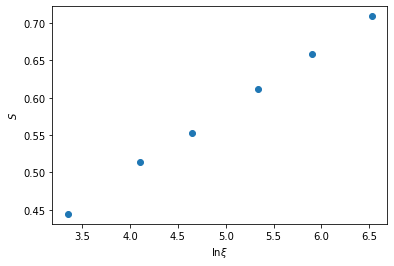

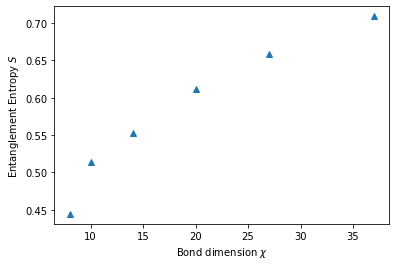

In [94]:
logxi_list = np.log(xi_list)

chis = chi_list[:-4]
xs = logxi_list[:-4]
ys = S_list[:-4]
plt.plot(xs, ys, 'o')
plt.xlabel(r'$\ln \xi$')
plt.ylabel(r'$S$')
plt.show()

plt.plot(chis, ys, '^')
plt.xlabel(r'Bond dimension $\chi$')
plt.ylabel(r'Entanglement Entropy $S$')
plt.show()

Apparently the 101 point is still gapless. Why the other nearby points missed?

In [96]:
chi_list = [int(2**n) for n in np.linspace(3, 6, 8)]
Jx, Jy, Jz = get_xyz(.5, .5, biased=False)
S_list, xi_list = finite_scaling(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    chi_list=chi_list,
    L=2,
    save_and_load=True,
)

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.01e-05
Call psi.canonical_form()
DMRG finished after 40 sweeps.
total size = 1224, maximum chi = 8
Before the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000093+0j)
After the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8]
Computing properties
Optimizing
Loop for chi=8 done.
============================== END ==============================


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  10 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Co

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.36e-05
Call psi.canonical_form()
DMRG finished after 70 sweeps.
total size = 1896, maximum chi = 10
Before the canonicalization:
Bond dim =  [10, 10, 10, 10, 10, 10, 10, 10]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000042+0j)
After the canonicalization:
Bond dim =  [10, 10, 10, 10, 10, 10, 10, 10]
Computing properties
Optimizing
Loop for chi=10 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 f

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774022236166, S = 0.5510591763404871, norm_err = 5.9e-05
Current memory usage 345.6 MB, time elapsed: 19.1 s
Delta E = -1.4456e-11, Delta S = 1.5730e-04 (per sweep)
max_trunc_err = 6.8032e-08, max_E_trunc = 4.8331e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774022724220, S = 0.5517010711719244, norm_err = 4.9e-05
Current memory usage 345.6 MB, time elapsed: 19.8 s
Delta E = -9.7611e-12, Delta S = 1.2838e-04 (per sweep)
max_trunc_err = 6.8655e-08, max_E_trunc = 4.8764e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774023057003, S = 0.5522251862159497, norm_err = 4.0e-05
Current memory usage 345.6 MB, time elapsed: 20.6 s
Delta E = -6.6557e-12, Delta S = 1.0482e-04 (per sweep)
max_trunc_err = 6.9167e-08, max_E_trunc = 4.9120e-08
MPS bond dimensions: [14, 14, 14, 14, 14, 14, 14, 14]
U

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.18e-05
Call psi.canonical_form()
DMRG finished after 95 sweeps.
total size = 2456, maximum chi = 14
Before the canonicalization:
Bond dim =  [14, 14, 14, 14, 14, 14, 14, 14]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+0j)
After the canonicalization:
Bond dim =  [14, 14, 14, 14, 14, 14, 14, 14]
Computing properties
Optimizing
Loop for chi=14 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 fo

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774488462069, S = 0.5869620406713459, norm_err = 1.6e-04
Current memory usage 345.6 MB, time elapsed: 17.3 s
Delta E = -6.5561e-11, Delta S = 4.0805e-04 (per sweep)
max_trunc_err = 1.4963e-08, max_E_trunc = 1.1882e-08
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774490978580, S = 0.5894053853309777, norm_err = 2.0e-04
Current memory usage 345.6 MB, time elapsed: 18.1 s
Delta E = -5.0330e-11, Delta S = 4.8867e-04 (per sweep)
max_trunc_err = 1.5462e-08, max_E_trunc = 1.2275e-08
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774492945753, S = 0.5907730733967453, norm_err = 9.9e-05
Current memory usage 345.6 MB, time elapsed: 18.9 s
Delta E = -3.9343e-11, Delta S = 2.7354e-04 (per sweep)
max_trunc_err = 1.6077e-08, max_E_trunc = 1.2800e-08
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19]
U

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.74e-05
Call psi.canonical_form()
DMRG finished after 110 sweeps.
total size = 2792, maximum chi = 19
Before the canonicalization:
Bond dim =  [19, 19, 19, 19, 19, 19, 19, 19]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000007+0j)
After the canonicalization:
Bond dim =  [19, 19, 19, 19, 19, 19, 19, 19]
Computing properties
Optimizing
Loop for chi=19 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 f

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774623260641, S = 0.6069255257627282, norm_err = 1.8e-04
Current memory usage 345.6 MB, time elapsed: 23.6 s
Delta E = -1.0874e-10, Delta S = 5.7311e-04 (per sweep)
max_trunc_err = 2.4118e-09, max_E_trunc = 1.7354e-09
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774628005255, S = 0.6101650417298281, norm_err = 2.1e-04
Current memory usage 345.6 MB, time elapsed: 24.8 s
Delta E = -9.4892e-11, Delta S = 6.4790e-04 (per sweep)
max_trunc_err = 2.5572e-09, max_E_trunc = 1.8398e-09
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774631967596, S = 0.6136999850877084, norm_err = 2.9e-04
Current memory usage 345.6 MB, time elapsed: 26.1 s
Delta E = -7.9247e-11, Delta S = 7.0699e-04 (per sweep)
max_trunc_err = 2.6954e-09, max_E_trunc = 1.9397e-09
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26]
U

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.86e-05
Call psi.canonical_form()
DMRG finished after 170 sweeps.
total size = 4136, maximum chi = 26
Before the canonicalization:
Bond dim =  [26, 26, 26, 26, 26, 26, 26, 26]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000002+0j)
After the canonicalization:
Bond dim =  [26, 26, 26, 26, 26, 26, 26, 26]
Computing properties
Optimizing
Loop for chi=26 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774651417283, S = 0.6156965939249905, norm_err = 2.9e-04
Current memory usage 345.6 MB, time elapsed: 27.4 s
Delta E = -1.1554e-10, Delta S = 7.7226e-04 (per sweep)
max_trunc_err = 3.1147e-10, max_E_trunc = 2.4838e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774656396908, S = 0.6193062210972498, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 28.6 s
Delta E = -9.9593e-11, Delta S = 7.2193e-04 (per sweep)
max_trunc_err = 3.3805e-10, max_E_trunc = 2.6921e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774660715232, S = 0.6227667882003005, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 29.8 s
Delta E = -8.6366e-11, Delta S = 6.9211e-04 (per sweep)
max_trunc_err = 3.6452e-10, max_E_trunc = 2.8973e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774690521327, S = 0.6643525119081677, norm_err = 1.2e-04
Current memory usage 345.6 MB, time elapsed: 54.0 s
Delta E = -1.1996e-11, Delta S = 3.1901e-04 (per sweep)
max_trunc_err = 7.9763e-10, max_E_trunc = 6.2892e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774691066669, S = 0.6659024631212033, norm_err = 1.2e-04
Current memory usage 345.6 MB, time elapsed: 55.2 s
Delta E = -1.0907e-11, Delta S = 3.0999e-04 (per sweep)
max_trunc_err = 8.1779e-10, max_E_trunc = 6.4426e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774691566820, S = 0.6673953060452589, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 56.4 s
Delta E = -1.0003e-11, Delta S = 2.9857e-04 (per sweep)
max_trunc_err = 8.3803e-10, max_E_trunc = 6.6001e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774696069813, S = 0.6869962339016639, norm_err = 5.2e-05
Current memory usage 345.6 MB, time elapsed: 77.5 s
Delta E = -2.1998e-12, Delta S = 1.7974e-04 (per sweep)
max_trunc_err = 1.1268e-09, max_E_trunc = 8.8471e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774696026896, S = 0.6876858524618934, norm_err = 6.5e-05
Current memory usage 345.6 MB, time elapsed: 78.9 s
Delta E = 8.5834e-13, Delta S = 1.3792e-04 (per sweep)
max_trunc_err = 1.1435e-09, max_E_trunc = 8.9688e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774696321914, S = 0.6884690075804392, norm_err = 6.4e-05
Current memory usage 345.6 MB, time elapsed: 80.2 s
Delta E = -5.9003e-12, Delta S = 1.5663e-04 (per sweep)
max_trunc_err = 1.1479e-09, max_E_trunc = 9.0154e-10
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.67e-05
Call psi.canonical_form()
DMRG finished after 350 sweeps.
total size = 8168, maximum chi = 35
Before the canonicalization:
Bond dim =  [35, 35, 35, 35, 35, 35, 35, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998+0j)
After the canonicalization:
Bond dim =  [35, 35, 35, 35, 35, 35, 35, 35]
Computing properties
Optimizing
Loop for chi=35 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeM

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774664921396, S = 0.6242929083543688, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 31.2 s
Delta E = -9.0492e-11, Delta S = 7.2388e-04 (per sweep)
max_trunc_err = 4.3885e-11, max_E_trunc = 3.4674e-11
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774668889617, S = 0.6277380770512910, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 32.5 s
Delta E = -7.9364e-11, Delta S = 6.8903e-04 (per sweep)
max_trunc_err = 4.8499e-11, max_E_trunc = 3.8142e-11
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774672391509, S = 0.6310729399450808, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 33.7 s
Delta E = -7.0038e-11, Delta S = 6.6697e-04 (per sweep)
max_trunc_err = 5.3157e-11, max_E_trunc = 4.1808e-11
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774699255318, S = 0.6741498679881125, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 57.6 s
Delta E = -1.2683e-11, Delta S = 3.6651e-04 (per sweep)
max_trunc_err = 1.4564e-10, max_E_trunc = 1.1266e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774699844429, S = 0.6758800173367134, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 58.9 s
Delta E = -1.1782e-11, Delta S = 3.4603e-04 (per sweep)
max_trunc_err = 1.5079e-10, max_E_trunc = 1.1698e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774700388385, S = 0.6776228736817143, norm_err = 1.2e-04
Current memory usage 345.6 MB, time elapsed: 60.2 s
Delta E = -1.0879e-11, Delta S = 3.4857e-04 (per sweep)
max_trunc_err = 1.5621e-10, max_E_trunc = 1.2125e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774705946144, S = 0.7019077200914374, norm_err = 8.2e-05
Current memory usage 345.6 MB, time elapsed: 83.7 s
Delta E = -3.5115e-12, Delta S = 2.1637e-04 (per sweep)
max_trunc_err = 2.4256e-10, max_E_trunc = 1.8815e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774706111345, S = 0.7029636683579367, norm_err = 7.8e-05
Current memory usage 345.6 MB, time elapsed: 84.9 s
Delta E = -3.3040e-12, Delta S = 2.1119e-04 (per sweep)
max_trunc_err = 2.4692e-10, max_E_trunc = 1.9111e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774706266172, S = 0.7040148173127492, norm_err = 8.2e-05
Current memory usage 345.6 MB, time elapsed: 86.2 s
Delta E = -3.0965e-12, Delta S = 2.1023e-04 (per sweep)
max_trunc_err = 2.5122e-10, max_E_trunc = 1.9452e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774708038266, S = 0.7194068382227140, norm_err = 5.7e-05
Current memory usage 345.6 MB, time elapsed: 110.4 s
Delta E = -1.2719e-12, Delta S = 1.4631e-04 (per sweep)
max_trunc_err = 3.1978e-10, max_E_trunc = 2.4761e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774708098946, S = 0.7200986470402182, norm_err = 5.1e-05
Current memory usage 345.6 MB, time elapsed: 111.7 s
Delta E = -1.2136e-12, Delta S = 1.3836e-04 (per sweep)
max_trunc_err = 3.2305e-10, max_E_trunc = 2.5022e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47, 47]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774708154653, S = 0.7207786070139868, norm_err = 5.2e-05
Current memory usage 345.6 MB, time elapsed: 113.0 s
Delta E = -1.1141e-12, Delta S = 1.3599e-04 (per sweep)
max_trunc_err = 3.2641e-10, max_E_trunc = 2.5216e-10
MPS bond dimensions: [47, 47, 47, 47, 47, 47, 47,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.13e-05
Call psi.canonical_form()
DMRG finished after 435 sweeps.
total size = 10072, maximum chi = 47
Before the canonicalization:
Bond dim =  [47, 47, 47, 47, 47, 47, 47, 47]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000004+0j)
After the canonicalization:
Bond dim =  [47, 47, 47, 47, 47, 47, 47, 47]
Computing properties
Optimizing
Loop for chi=47 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSna

Updating environment
..
sweep 80, age = 1960
Energy = -0.0795774669688374, S = 0.6291472613355067, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 37.8 s
Delta E = -7.9550e-11, Delta S = 6.9739e-04 (per sweep)
max_trunc_err = 2.2428e-11, max_E_trunc = 1.5007e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 85, age = 2072
Energy = -0.0795774673208562, S = 0.6324999812583021, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 39.5 s
Delta E = -7.0404e-11, Delta S = 6.7054e-04 (per sweep)
max_trunc_err = 2.5116e-11, max_E_trunc = 1.6541e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 90, age = 2184
Energy = -0.0795774676339160, S = 0.6357278926944023, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 41.2 s
Delta E = -6.2612e-11, Delta S = 6.4558e-04 (per sweep)
max_trunc_err = 2.7848e-11, max_E_trunc = 1.8019e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
U

Updating environment
..
sweep 180, age = 4200
Energy = -0.0795774701385952, S = 0.6788984488124121, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 70.6 s
Delta E = -1.2585e-11, Delta S = 3.7429e-04 (per sweep)
max_trunc_err = 8.3472e-11, max_E_trunc = 5.4001e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 185, age = 4312
Energy = -0.0795774701970728, S = 0.6807170041534996, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 72.2 s
Delta E = -1.1696e-11, Delta S = 3.6371e-04 (per sweep)
max_trunc_err = 8.6980e-11, max_E_trunc = 5.6843e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 190, age = 4424
Energy = -0.0795774702516709, S = 0.6825008316682637, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 73.8 s
Delta E = -1.0920e-11, Delta S = 3.5677e-04 (per sweep)
max_trunc_err = 9.0531e-11, max_E_trunc = 5.8378e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64

Updating environment
..
sweep 280, age = 6440
Energy = -0.0795774708298538, S = 0.7087376255890824, norm_err = 9.1e-05
Current memory usage 345.6 MB, time elapsed: 102.1 s
Delta E = -3.8575e-12, Delta S = 2.4477e-04 (per sweep)
max_trunc_err = 1.5560e-10, max_E_trunc = 1.0232e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 285, age = 6552
Energy = -0.0795774708482284, S = 0.7099395908426778, norm_err = 9.0e-05
Current memory usage 345.6 MB, time elapsed: 103.7 s
Delta E = -3.6749e-12, Delta S = 2.4039e-04 (per sweep)
max_trunc_err = 1.5919e-10, max_E_trunc = 1.0368e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 290, age = 6664
Energy = -0.0795774708657291, S = 0.7111197280575003, norm_err = 8.8e-05
Current memory usage 345.6 MB, time elapsed: 105.3 s
Delta E = -3.5001e-12, Delta S = 2.3603e-04 (per sweep)
max_trunc_err = 1.6277e-10, max_E_trunc = 1.0675e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64,

Updating environment
..
sweep 380, age = 8680
Energy = -0.0795774710750621, S = 0.7292365580623458, norm_err = 6.5e-05
Current memory usage 345.6 MB, time elapsed: 136.2 s
Delta E = -1.5518e-12, Delta S = 1.7455e-04 (per sweep)
max_trunc_err = 2.2472e-10, max_E_trunc = 1.4722e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 385, age = 8792
Energy = -0.0795774710825867, S = 0.7300958517350002, norm_err = 6.4e-05
Current memory usage 345.6 MB, time elapsed: 137.7 s
Delta E = -1.5049e-12, Delta S = 1.7186e-04 (per sweep)
max_trunc_err = 2.2799e-10, max_E_trunc = 1.4802e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 390, age = 8904
Energy = -0.0795774710900190, S = 0.7309419326923497, norm_err = 6.3e-05
Current memory usage 345.6 MB, time elapsed: 139.3 s
Delta E = -1.4865e-12, Delta S = 1.6922e-04 (per sweep)
max_trunc_err = 2.3123e-10, max_E_trunc = 1.4984e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64,

Updating environment
..
sweep 480, age = 10920
Energy = -0.0795774711834127, S = 0.7441955198904924, norm_err = 4.8e-05
Current memory usage 345.6 MB, time elapsed: 168.2 s
Delta E = -7.2191e-13, Delta S = 1.2987e-04 (per sweep)
max_trunc_err = 2.8585e-10, max_E_trunc = 1.8645e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 485, age = 11032
Energy = -0.0795774711871076, S = 0.7448354208711487, norm_err = 4.8e-05
Current memory usage 345.6 MB, time elapsed: 169.8 s
Delta E = -7.3896e-13, Delta S = 1.2798e-04 (per sweep)
max_trunc_err = 2.8867e-10, max_E_trunc = 1.8815e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 490, age = 11144
Energy = -0.0795774711902766, S = 0.7454666114180338, norm_err = 4.7e-05
Current memory usage 345.6 MB, time elapsed: 171.4 s
Delta E = -6.3380e-13, Delta S = 1.2624e-04 (per sweep)
max_trunc_err = 2.9146e-10, max_E_trunc = 1.8952e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 

Updating environment
..
sweep 580, age = 13160
Energy = -0.0795774712391193, S = 0.7555249628015070, norm_err = 3.7e-05
Current memory usage 345.6 MB, time elapsed: 201.1 s
Delta E = -3.4106e-13, Delta S = 1.0005e-04 (per sweep)
max_trunc_err = 3.4702e-10, max_E_trunc = 2.0668e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
..
sweep 585, age = 13272
Energy = -0.0795774712415209, S = 0.7560172007857875, norm_err = 3.7e-05
Current memory usage 345.6 MB, time elapsed: 202.8 s
Delta E = -4.8033e-13, Delta S = 9.8448e-05 (per sweep)
max_trunc_err = 3.4890e-10, max_E_trunc = 2.0555e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=3.66e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.54e-05
Call psi.canonical_form()
DMRG finished after 585 sweeps.
total size = 13432, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999943+0j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


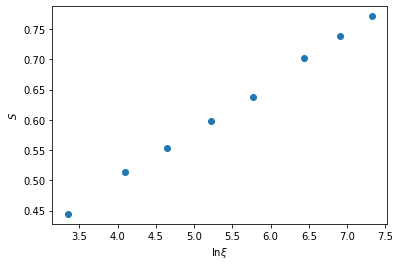

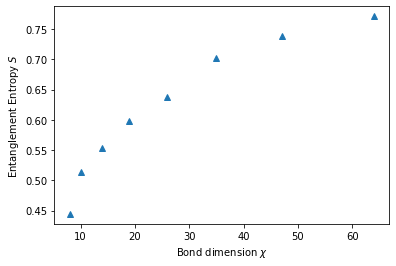

In [98]:
logxi_list = np.log(xi_list)


chis = chi_list
xs = logxi_list
ys = S_list
plt.plot(xs, ys, 'o')
plt.xlabel(r'$\ln \xi$')
plt.ylabel(r'$S$')
plt.show()

plt.plot(chis, ys, '^')
plt.xlabel(r'Bond dimension $\chi$')
plt.ylabel(r'Entanglement Entropy $S$')
plt.show()

In [99]:

L = 2

chi_list = [int(2**n) for n in np.linspace(3, 6, 8)]
Jx0, Jy0, Jz0 = get_xyz(.5, .5, biased=False)
Jx, Jy, Jz = get_xyz(.6, .4, biased=False)
for chi in chi_list:
    initial_data = load_data(Jx=Jx0, Jy=Jy0, Jz=Jz0, L=L, chi=chi)
    initial_psi = initial_data['psi']
    data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=initial_psi)
    

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Co

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0759877083064542, S = nan, norm_err = 4.3e-06
Current memory usage 345.6 MB, time elapsed: 7.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3266e-06, max_E_trunc = 1.1092e-06
MPS bond dimensions: [10, 10, 10, 10, 10, 10, 10, 10]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0785205433132594, S = nan, norm_err = 2.4e-07
Current memory usage 345.6 MB, time elapsed: 11.1 s
Delta E = -2.5328e-04, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2093e-06, max_E_trunc = 1.0961e-06
MPS bond dimensions: [10, 10, 10, 10, 10, 10, 10,

Updating environment
.....
sweep 20, age = 648
Energy = -0.0785208382810576, S = nan, norm_err = 1.6e-08
Current memory usage 345.6 MB, time elapsed: 12.3 s
Delta E = -6.5967e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1262e-08, max_E_trunc = 2.0141e-09
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 888
Energy = -0.0785208392939722, S = 0.4684609380401478, norm_err = 7.3e-10
Current memory usage 345.6 MB, time elapsed: 14.5 s
Delta E = -1.0129e-10, Delta S = nan (per sweep)
max_trunc_err = 2.2724e-09, max_E_trunc = 1.5173e-09
MPS bond dimensions: [19, 19, 19, 19, 19, 19, 19, 19]
Updating environment
.....
sweep 40, age = 1128
Energy = -0.0785208392908787, S = 0.4684609796681479, norm_err = 6.4e-10
Current memory usage 345.6 MB, time elapsed: 17.0 s
Delta E = 3.0935e-13, Delta S = 4.1628e-09 (per sweep)
max_trunc_err = 2.3005e-09, max_E_trunc = 1.544

Updating environment
.....
sweep 40, age = 1128
Energy = -0.0785208398485828, S = 0.4684623350621264, norm_err = 3.4e-12
Current memory usage 345.6 MB, time elapsed: 17.4 s
Delta E = -8.8818e-16, Delta S = -5.1782e-12 (per sweep)
max_trunc_err = 9.5395e-12, max_E_trunc = 6.3380e-12
MPS bond dimensions: [35, 35, 35, 35, 35, 35, 35, 35]
DMRG finished after 40 sweeps.
total size = 1128, maximum chi = 35
Before the canonicalization:
Bond dim =  [35, 35, 35, 35, 35, 35, 35, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000029+4.1737970811477404e-16j)
After the canonicalization:
Bond dim =  [35, 35, 35, 35, 35, 35, 35, 35]
Computing properties
Optimizing
Loop for chi=35 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'=

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [47, 43, 47, 43, 47, 43, 47, 43]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000016-7.20971079937135e-16j)
After the canonicalization:
Bond dim =  [47, 43, 47, 43, 47, 43, 47, 43]
Computing properties
Optimizing
Loop for chi=47 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=0.1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Let's do the comb method

In [ ]:
L = 2
a_list = np.linspace(-1, 0, 11)
b_list = np.linspace(0, 1, 11)


prefix = 'data/comb/'
# if there is no such folder, create another one; if exists, doesn't matter
Path(prefix).mkdir(parents=True, exist_ok=True)
run_save = save_after_run(run_atomic, folder_prefix=prefix)

chi = 32

In [58]:
def comb(a_list, b_list, chi):
    initial_psi = None
    for a in a_list:
        b0 = 0
        Jx, Jy, Jz = get_xyz(a, b0, biased=False)
        data = run_save(
            Jx=Jx, 
            Jy=Jy, 
            Jz=Jz, 
            L=L, 
            chi=chi, 
            initial_psi=initial_psi.copy() if initial_psi is not None else None,
        )
        if data == 0:
            # file exists; load the data
            data = load_data(
                Jx=Jx,
                Jy=Jy,
                Jz=Jz,
                L=L,
                chi=chi,
                prefix=prefix,
            )

        # output state of this DMRG serves as the input of the next
        initial_psi = data['psi'].copy()
        S_dict[(a, b0, chi)] = np.mean(initial_psi.entanglement_entropy())
        xi_dict[(a, b0, chi)] = initial_psi.correlation_length()


        initial_psi_a = data['psi'].copy()
        for b in b_list:
            Jx, Jy, Jz = get_xyz(a, b, biased=False)
            data = run_save(
                Jx=Jx, 
                Jy=Jy, 
                Jz=Jz, 
                L=L, 
                chi=chi, 
                initial_psi=initial_psi_a.copy(),
            )
            if data == 0:
                # file exists; load the data
                data = load_data(
                    Jx=Jx,
                    Jy=Jy,
                    Jz=Jz,
                    L=L,
                    chi=chi,
                    prefix=prefix,
                )

            # output state of this DMRG serves as the input of the next
            initial_psi_a = data['psi'].copy()
            S_dict[(a, b, chi)] = np.mean(initial_psi_a.entanglement_entropy())
            xi_dict[(a, b, chi)] = initial_psi_a.correlation_length()

            pass

        pass

In [106]:
comb(a_list, b_list, chi)

This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.


In [109]:
L = 2
a_list = np.linspace(-1, 0, 11)
b_list = np.linspace(0, 1, 11)


prefix = 'data/comb/'
# if there is no such folder, create another one; if exists, doesn't matter
Path(prefix).mkdir(parents=True, exist_ok=True)
run_save = save_after_run(run_atomic, folder_prefix=prefix)

chi = 64
initial_psi = None

start = time.time()
comb(a_list, b_list, chi)
end = time.time()
print("\nElapsed Time: ", end-start)

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'

Updating environment
.....
sweep 180, age = 4488
Energy = -0.1022887318641317, S = 0.9704491023347125, norm_err = 1.8e-04
Current memory usage 345.6 MB, time elapsed: 79.4 s
Delta E = -3.9880e-11, Delta S = 5.0095e-04 (per sweep)
max_trunc_err = 2.4199e-10, max_E_trunc = 1.8338e-10
MPS bond dimensions: [64, 63, 64, 64, 64, 38, 64, 36]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.1022887322192574, S = 0.9742560128822225, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 83.2 s
Delta E = -3.5513e-11, Delta S = 3.8069e-04 (per sweep)
max_trunc_err = 2.6863e-10, max_E_trunc = 2.0515e-10
MPS bond dimensions: [64, 63, 64, 64, 64, 34, 64, 36]
Updating environment
.....
sweep 200, age = 4968
Energy = -0.1022887325059827, S = 0.9781207272258918, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 86.4 s
Delta E = -2.8673e-11, Delta S = 3.8647e-04 (per sweep)
max_trunc_err = 2.9287e-10, max_E_trunc = 2.2430e-10
MPS bond dimensions: [64, 64, 64, 63, 64, 4

Updating environment
.....
sweep 380, age = 9288
Energy = -0.1022887342586074, S = 1.0228901568843085, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 162.5 s
Delta E = -2.4951e-11, Delta S = 1.4145e-04 (per sweep)
max_trunc_err = 6.2837e-10, max_E_trunc = 4.8374e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 36, 64, 40]
Updating environment
.....
sweep 390, age = 9528
Energy = -0.1022887343011192, S = 1.0243828114683136, norm_err = 7.5e-05
Current memory usage 345.6 MB, time elapsed: 167.7 s
Delta E = -4.2512e-12, Delta S = 1.4927e-04 (per sweep)
max_trunc_err = 6.4039e-10, max_E_trunc = 4.8908e-10
MPS bond dimensions: [64, 62, 64, 64, 64, 41, 64, 38]
Updating environment
.....
sweep 400, age = 9768
Energy = -0.1022887342998828, S = 1.0258648998603124, norm_err = 5.1e-05
Current memory usage 345.6 MB, time elapsed: 171.1 s
Delta E = 1.2363e-13, Delta S = 1.4821e-04 (per sweep)
max_trunc_err = 6.3094e-10, max_E_trunc = 4.8192e-10
MPS bond dimensions: [64, 64, 64, 64, 64,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.31e-04
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 480 sweeps.
total size = 12088, maximum chi = 64


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [64, 43, 64, 43, 64, 33, 64, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000104-3.497809032506676e-16j)
After the canonicalization:
Bond dim =  [64, 43, 64, 43, 64, 33, 64, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [21, 14, 28, 14, 21, 14, 28, 14]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038-6.520738896134136e-18j)
After the canonicalization:
Bond dim =  [21, 14, 28, 14, 21, 14, 28, 14]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [13, 10, 20, 10, 13, 10, 20, 10]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009-1.730462103630841e-16j)
After the canonicalization:
Bond dim =  [13, 10, 20, 10, 13, 10, 20, 10]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000098+1.572952747990626e-16j)
After the canonicalization:
Bond dim =  [11, 7, 14, 7, 11, 7, 14, 7]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 f

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 40, age = 1128
Energy = -0.1082831328191638, S = 0.1912918746181491, norm_err = 1.1e-14
Current memory usage 345.6 MB, time elapsed: 13.4 s
Delta E = 2.6645e-16, Delta S = 4.8572e-16 (per sweep)
max_trunc_err = 1.4528e-20, max_E_trunc = 1.5632e-13
MPS bond dimensions: [13, 9, 18, 9, 13, 8, 16, 8]
DMRG finished after 40 sweeps.
total size = 1128, maximum chi = 18
Before the canonicalization:
Bond dim =  [9, 7, 10, 5, 9, 7, 10, 5]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000024+3.0414907924920655e-17j)
After the canonicalization:
Bond dim =  [9, 7, 10, 5, 9, 7, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 40, age = 1128
Energy = -0.1106863882872045, S = 0.1845340591617560, norm_err = 1.6e-15
Current memory usage 345.6 MB, time elapsed: 13.0 s
Delta E = -1.8652e-15, Delta S = -1.5615e-14 (per sweep)
max_trunc_err = 1.8077e-21, max_E_trunc = 1.9895e-13
MPS bond dimensions: [11, 7, 14, 7, 11, 7, 14, 7]
DMRG finished after 40 sweeps.
total size = 1128, maximum chi = 14
Before the canonicalization:
Bond dim =  [7, 5, 10, 5, 7, 5, 10, 5]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999978-3.348196498561988e-16j)
After the canonicalization:
Bond dim =  [7, 5, 10, 5, 7, 5, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.8 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 40, age = 1128
Energy = -0.1132843506426608, S = 0.1799772346262266, norm_err = 1.4e-15
Current memory usage 345.6 MB, time elapsed: 12.0 s
Delta E = 9.7700e-16, Delta S = 6.4948e-16 (per sweep)
max_trunc_err = 2.8254e-22, max_E_trunc = 1.2790e-13
MPS bond dimensions: [9, 6, 12, 6, 9, 6, 12, 6]
DMRG finished after 40 sweeps.
total size = 1128, maximum chi = 12
Before the canonicalization:
Bond dim =  [6, 5, 10, 5, 6, 5, 10, 5]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999996+1.819545647133939e-16j)
After the canonicalization:
Bond dim =  [6, 5, 10, 5, 6, 5, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.85 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 f

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000007+1.967571719000474e-16j)
After the canonicalization:
Bond dim =  [5, 3, 6, 3, 5, 3, 6, 3]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.9 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for c

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999987-7.911984355987567e-18j)
After the canonicalization:
Bond dim =  [4, 3, 6, 3, 4, 3, 6, 3]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.95 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-1.0 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0925020424052052, S = nan, norm_err = 1.9e-03
Current memory usage 345.6 MB, time elapsed: 7.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7923e-12, max_E_trunc = 3.4461e-12
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 648
Energy 

Updating environment
.....
sweep 190, age = 4728
Energy = -0.0925026141387342, S = 0.9615298679920617, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 84.0 s
Delta E = -2.5507e-11, Delta S = 3.6778e-04 (per sweep)
max_trunc_err = 3.6535e-09, max_E_trunc = 2.6029e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 200, age = 4968
Energy = -0.0925026143525471, S = 0.9650328506608825, norm_err = 1.0e-04
Current memory usage 345.6 MB, time elapsed: 87.5 s
Delta E = -2.1381e-11, Delta S = 3.5030e-04 (per sweep)
max_trunc_err = 3.8574e-09, max_E_trunc = 2.7333e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 210, age = 5208
Energy = -0.0925026145335437, S = 0.9682043016062476, norm_err = 9.7e-05
Current memory usage 345.6 MB, time elapsed: 90.9 s
Delta E = -1.8100e-11, Delta S = 3.1715e-04 (per sweep)
max_trunc_err = 4.0532e-09, max_E_trunc = 2.8517e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.05e-04
Call psi.canonical_form()
DMRG finished after 300 sweeps.
total size = 7768, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000104-3.039051229317362e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.4 for confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [29, 30, 42, 29, 30, 30, 21, 29]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+2.5673907444456745e-16j)
After the canonicalization:
Bond dim =  [29, 30, 42, 29, 30, 30, 21, 29]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [21, 22, 30, 22, 21, 22, 30, 21]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993-7.390609945893644e-17j)
After the canonicalization:
Bond dim =  [21, 22, 30, 22, 21, 22, 30, 21]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [17, 16, 24, 16, 18, 16, 24, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000082+1.1101839781337092e-16j)
After the canonicalization:
Bond dim =  [17, 16, 24, 16, 18, 16, 24, 16]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [13, 14, 19, 13, 14, 14, 20, 13]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999936+1.6283797502857932e-16j)
After the canonicalization:
Bond dim =  [13, 14, 19, 13, 14, 14, 20, 13]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [12, 12, 12, 12, 12, 12, 18, 12]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044-4.983686969061235e-16j)
After the canonicalization:
Bond dim =  [12, 12, 12, 12, 12, 12, 18, 12]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [10, 11, 16, 11, 10, 11, 16, 11]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049+4.039052109941974e-16j)
After the canonicalization:
Bond dim =  [10, 11, 16, 11, 10, 11, 16, 11]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.8 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [9, 9, 8, 9, 9, 9, 14, 9]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993+3.882683671776953e-16j)
After the canonicalization:
Bond dim =  [9, 9, 8, 9, 9, 9, 14, 9]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.85 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for co

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999944-3.924818320107868e-16j)
After the canonicalization:
Bond dim =  [8, 8, 12, 8, 8, 8, 12, 8]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.9 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.95 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'

Updating environment
.....
sweep 180, age = 4488
Energy = -0.0838357521090671, S = 1.0499737680330730, norm_err = 1.5e-03
Current memory usage 345.6 MB, time elapsed: 84.9 s
Delta E = 1.1276e-10, Delta S = -5.8096e-05 (per sweep)
max_trunc_err = 7.9211e-09, max_E_trunc = 5.2219e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=1.49e-03
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.30e-03
Call psi.canonical_form()
DMRG finished after 180 sweeps.
total size = 4888, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000056+7.147060721024445e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.35 for conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [37, 35, 51, 35, 37, 35, 32, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000064-1.913558501660118e-16j)
After the canonicalization:
Bond dim =  [37, 35, 51, 35, 37, 35, 32, 35]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [27, 25, 38, 25, 28, 26, 23, 25]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049-3.512818197893735e-16j)
After the canonicalization:
Bond dim =  [27, 25, 38, 25, 28, 26, 23, 25]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [23, 20, 19, 20, 23, 20, 30, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013+1.4470134068450636e-16j)
After the canonicalization:
Bond dim =  [23, 20, 19, 20, 23, 20, 30, 20]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [18, 18, 27, 17, 19, 19, 23, 18]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+8.133172965333413e-16j)
After the canonicalization:
Bond dim =  [18, 18, 27, 17, 19, 19, 23, 18]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [15, 15, 21, 15, 15, 15, 17, 15]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000084+7.988403792877195e-16j)
After the canonicalization:
Bond dim =  [15, 15, 21, 15, 15, 15, 17, 15]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [12, 13, 10, 13, 12, 13, 18, 13]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999938+3.78524997252102e-16j)
After the canonicalization:
Bond dim =  [12, 13, 10, 13, 12, 13, 18, 13]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [10, 11, 18, 11, 10, 11, 18, 11]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000053-1.5083776112758388e-16j)
After the canonicalization:
Bond dim =  [10, 11, 18, 11, 10, 11, 18, 11]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.8 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000036+1.124892964606798e-16j)
After the canonicalization:
Bond dim =  [5, 5, 7, 5, 5, 5, 5, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.85 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000016+2.446182981841423e-16j)
After the canonicalization:
Bond dim =  [8, 8, 12, 8, 8, 8, 12, 8]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.9 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000009-8.41011447603919e-17j)
After the canonicalization:
Bond dim =  [4, 3, 6, 3, 4, 3, 6, 3]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.35 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for 

Updating environment
.....
sweep 170, age = 4248
Energy = -0.0768406064804061, S = 0.6632292719084817, norm_err = 1.4e-04
Current memory usage 345.6 MB, time elapsed: 72.0 s
Delta E = -2.3710e-11, Delta S = 4.0752e-04 (per sweep)
max_trunc_err = 5.0340e-09, max_E_trunc = 3.2596e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0768406066708707, S = 0.6671816634867546, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 75.4 s
Delta E = -1.9046e-11, Delta S = 3.9524e-04 (per sweep)
max_trunc_err = 5.3194e-09, max_E_trunc = 3.4404e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.0768406067742475, S = 0.6707913326089850, norm_err = 1.8e-04
Current memory usage 345.6 MB, time elapsed: 79.2 s
Delta E = -1.0338e-11, Delta S = 3.6097e-04 (per sweep)
max_trunc_err = 5.6200e-09, max_E_trunc = 3.6246e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.23e-05
Call psi.canonical_form()
DMRG finished after 330 sweeps.
total size = 8488, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999962+2.459512628283367e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.3 for confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [51, 46, 64, 46, 50, 46, 40, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993+2.0694499790303816e-16j)
After the canonicalization:
Bond dim =  [51, 46, 64, 46, 50, 46, 40, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [37, 37, 49, 36, 37, 36, 33, 37]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999956+1.2660072685675532e-16j)
After the canonicalization:
Bond dim =  [37, 37, 49, 36, 37, 36, 33, 37]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [27, 27, 41, 28, 28, 28, 27, 28]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000016-6.485136673861316e-16j)
After the canonicalization:
Bond dim =  [27, 27, 41, 28, 28, 28, 27, 28]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [23, 24, 34, 24, 22, 24, 20, 24]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000047-3.9105203798891463e-17j)
After the canonicalization:
Bond dim =  [23, 24, 34, 24, 22, 24, 20, 24]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [20, 18, 28, 19, 20, 19, 19, 18]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998-3.5512445032035023e-16j)
After the canonicalization:
Bond dim =  [20, 18, 28, 19, 20, 19, 19, 18]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [17, 17, 24, 16, 17, 16, 17, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000015+4.669207025820608e-16j)
After the canonicalization:
Bond dim =  [17, 17, 24, 16, 17, 16, 17, 16]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000062+1.3902706138202904e-16j)
After the canonicalization:
Bond dim =  [7, 7, 10, 7, 7, 7, 9, 7]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 fo

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [10, 11, 18, 11, 10, 11, 18, 11]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000062-1.1125293365218524e-16j)
After the canonicalization:
Bond dim =  [10, 11, 18, 11, 10, 11, 18, 11]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.8 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [9, 9, 8, 9, 9, 9, 14, 9]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-5.251080381508871e-17j)
After the canonicalization:
Bond dim =  [9, 9, 8, 9, 9, 9, 14, 9]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.85 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000029+2.268721721346727e-16j)
After the canonicalization:
Bond dim =  [5, 3, 6, 3, 5, 3, 6, 3]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for c

Updating environment
.....
sweep 170, age = 4248
Energy = -0.0727155499766390, S = 0.7651196215701319, norm_err = 2.2e-04
Current memory usage 345.6 MB, time elapsed: 76.6 s
Delta E = 7.0754e-11, Delta S = 7.3489e-05 (per sweep)
max_trunc_err = 4.6389e-08, max_E_trunc = 2.7702e-08
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=2.17e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.40e-05
Call psi.canonical_form()
DMRG finished after 170 sweeps.
total size = 4648, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000006-2.970713952610282e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 63, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999989-7.618219059078281e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 63, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [61, 58, 64, 58, 60, 60, 47, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044+3.167911524961744e-16j)
After the canonicalization:
Bond dim =  [61, 58, 64, 58, 60, 60, 47, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [47, 46, 62, 46, 47, 46, 35, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-8.922335009406899e-17j)
After the canonicalization:
Bond dim =  [47, 46, 62, 46, 47, 46, 35, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [36, 38, 48, 38, 37, 38, 27, 38]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1-3.6370291696397754e-16j)
After the canonicalization:
Bond dim =  [36, 38, 48, 38, 37, 38, 27, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [29, 31, 40, 31, 29, 30, 25, 30]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000138+2.37297822866624e-16j)
After the canonicalization:
Bond dim =  [29, 31, 40, 31, 29, 30, 25, 30]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.000000000000012-7.230642048123477e-17j)
After the canonicalization:
Bond dim =  [10, 10, 10, 10, 10, 10, 10, 10]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [17, 16, 24, 16, 18, 17, 24, 17]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000029-1.8193440202572871e-16j)
After the canonicalization:
Bond dim =  [17, 16, 24, 16, 18, 17, 24, 17]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [12, 13, 13, 13, 12, 13, 16, 13]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+1.0008750575028568e-16j)
After the canonicalization:
Bond dim =  [12, 13, 13, 13, 12, 13, 16, 13]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [10, 11, 16, 11, 10, 11, 16, 11]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000027+1.13352717342474e-16j)
After the canonicalization:
Bond dim =  [10, 11, 16, 11, 10, 11, 16, 11]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.8 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 40, age = 1128
Energy = -0.1132843506426600, S = 0.1799772346262115, norm_err = 1.1e-15
Current memory usage 345.6 MB, time elapsed: 11.9 s
Delta E = 1.7764e-16, Delta S = -9.2704e-16 (per sweep)
max_trunc_err = 9.3884e-21, max_E_trunc = 1.2790e-13
MPS bond dimensions: [9, 6, 12, 6, 9, 6, 12, 6]
DMRG finished after 40 sweeps.
total size = 1128, maximum chi = 12
Before the canonicalization:
Bond dim =  [6, 5, 10, 5, 6, 5, 10, 5]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000062+2.1385472230018592e-16j)
After the canonicalization:
Bond dim =  [6, 5, 10, 5, 6, 5, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 150 sweeps.
total size = 4088, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999898+7.835529100552741e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


================

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'

..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0795769490741909, S = nan, norm_err = 2.4e-03
Current memory usage 345.6 MB, time elapsed: 8.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6619e-16, max_E_trunc = 2.1316e-14
MPS bond dimensions: [50, 64, 54, 60, 64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0795773357028846, S = nan, norm_err = 1.3e-03
Current memory usage 345.6 MB, time elapsed: 20.5 s
Delta E = -3.8663e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3175e-13, max_E_trunc = 1.2079e-13
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64,

Updating environment
.....
sweep 200, age = 4968
Energy = -0.0795774700030165, S = 0.8562352292208920, norm_err = 2.4e-04
Current memory usage 345.6 MB, time elapsed: 120.4 s
Delta E = -1.4552e-11, Delta S = 4.0927e-04 (per sweep)
max_trunc_err = 2.8442e-10, max_E_trunc = 1.9554e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 210, age = 5208
Energy = -0.0795774701505962, S = 0.8600898007689302, norm_err = 1.3e-04
Current memory usage 345.6 MB, time elapsed: 126.7 s
Delta E = -1.4758e-11, Delta S = 3.8546e-04 (per sweep)
max_trunc_err = 3.0408e-10, max_E_trunc = 2.0736e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 220, age = 5448
Energy = -0.0795774701783074, S = 0.8635097909373159, norm_err = 4.4e-04
Current memory usage 345.6 MB, time elapsed: 132.2 s
Delta E = -2.7711e-12, Delta S = 3.4200e-04 (per sweep)
max_trunc_err = 3.2893e-10, max_E_trunc = 2.2573e-10
MPS bond dimensions: [64, 64, 64, 64, 64

norm_tol=1.00e-05 not reached, norm_err=4.16e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.92e-04
Call psi.canonical_form()
DMRG finished after 390 sweeps.
total size = 9928, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999942+2.5500435096859064e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [29, 31, 40, 30, 29, 30, 40, 30]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000058+4.86189476472925e-16j)
After the canonicalization:
Bond dim =  [29, 31, 40, 30, 29, 30, 40, 30]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [20, 19, 28, 19, 20, 18, 20, 18]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033-7.09412704447878e-16j)
After the canonicalization:
Bond dim =  [20, 19, 28, 19, 20, 18, 20, 18]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [15, 15, 15, 15, 15, 16, 21, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000001+8.670063079424911e-17j)
After the canonicalization:
Bond dim =  [15, 15, 15, 15, 15, 16, 21, 16]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [11, 12, 18, 12, 12, 12, 18, 12]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000001+7.875603454981803e-17j)
After the canonicalization:
Bond dim =  [11, 12, 18, 12, 12, 12, 18, 12]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.75 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000007+7.22063596384685e-18j)
After the canonicalization:
Bond dim =  [7, 5, 10, 5, 7, 5, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jz'=0.6 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for 

Updating environment
.....
sweep 170, age = 4248
Energy = -0.0817119344396033, S = 0.7308313818122358, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 128.7 s
Delta E = -1.5682e-11, Delta S = -6.4839e-04 (per sweep)
max_trunc_err = 1.0542e-09, max_E_trunc = 7.2100e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0817119343352068, S = 0.7428541453070092, norm_err = 7.9e-04
Current memory usage 345.6 MB, time elapsed: 136.4 s
Delta E = 1.0440e-11, Delta S = 1.2023e-03 (per sweep)
max_trunc_err = 1.0786e-09, max_E_trunc = 7.3732e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.0817119344026871, S = 0.7348053101210625, norm_err = 4.5e-04
Current memory usage 345.6 MB, time elapsed: 144.5 s
Delta E = -6.7480e-12, Delta S = -8.0488e-04 (per sweep)
max_trunc_err = 1.1108e-09, max_E_trunc = 7.5602e-10
MPS bond dimensions: [64, 64, 64, 64, 6

Updating environment
.....
sweep 370, age = 9048
Energy = -0.0817119342837955, S = 0.7634694293016817, norm_err = 8.2e-04
Current memory usage 345.6 MB, time elapsed: 265.4 s
Delta E = 3.9719e-12, Delta S = 1.3375e-03 (per sweep)
max_trunc_err = 1.6989e-09, max_E_trunc = 1.3869e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 380, age = 9288
Energy = -0.0817119343694515, S = 0.7521837959506428, norm_err = 6.2e-04
Current memory usage 345.6 MB, time elapsed: 272.8 s
Delta E = -8.5656e-12, Delta S = -1.1286e-03 (per sweep)
max_trunc_err = 1.7563e-09, max_E_trunc = 1.4052e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 390, age = 9528
Energy = -0.0817119342579602, S = 0.7641115512433775, norm_err = 8.8e-04
Current memory usage 345.6 MB, time elapsed: 279.9 s
Delta E = 1.1149e-11, Delta S = 1.1928e-03 (per sweep)
max_trunc_err = 1.7687e-09, max_E_trunc = 1.4120e-09
MPS bond dimensions: [64, 64, 64, 64, 64,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.70e-04
Call psi.canonical_form()
DMRG finished after 460 sweeps.
total size = 11608, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000022-8.734332701543224e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 40 sweeps.
total size = 1448, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000067-2.611565652263963e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.6 for config KitaevLadderSnakeModel


==============================START===============

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 62, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000022-5.160716550413823e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 62, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.4 for config KitaevLadderSnakeModel
Reading 'Jz'=0.6 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [13, 15, 13, 15, 13, 13, 17, 13]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013+5.482360377604269e-16j)
After the canonicalization:
Bond dim =  [13, 15, 13, 15, 13, 13, 17, 13]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [36, 38, 48, 38, 36, 38, 33, 38]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000075+5.677091076331602e-16j)
After the canonicalization:
Bond dim =  [36, 38, 48, 38, 36, 38, 33, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [22, 24, 34, 24, 23, 24, 23, 23]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000012-4.511544175509382e-16j)
After the canonicalization:
Bond dim =  [22, 24, 34, 24, 23, 24, 23, 23]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [18, 18, 26, 18, 19, 18, 19, 17]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004-7.189627702005707e-16j)
After the canonicalization:
Bond dim =  [18, 18, 26, 18, 19, 18, 19, 17]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [15, 14, 13, 14, 14, 14, 19, 13]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000064+1.8595482181106343e-16j)
After the canonicalization:
Bond dim =  [15, 14, 13, 14, 14, 14, 19, 13]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.7 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000029-2.1924754778242622e-16j)
After the canonicalization:
Bond dim =  [9, 7, 10, 5, 9, 7, 10, 5]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jz'=0.7 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 

Updating environment
.....
sweep 170, age = 4248
Energy = -0.0907637607959941, S = 0.7128698065183050, norm_err = 2.2e-04
Current memory usage 345.6 MB, time elapsed: 139.1 s
Delta E = -1.6126e-12, Delta S = 5.9914e-04 (per sweep)
max_trunc_err = 1.7647e-10, max_E_trunc = 1.3694e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0907637607931271, S = 0.7122263870448375, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 146.7 s
Delta E = 2.8670e-13, Delta S = -6.4342e-05 (per sweep)
max_trunc_err = 1.8404e-10, max_E_trunc = 1.4268e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=1.12e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.83e-05
Call psi.canonical_form()
DMRG finished after 180 sweeps.
total size = 4888, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000005-3.1473033814538587e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.48e-05
Call psi.canonical_form()
DMRG finished after 50 sweeps.
total size = 1768, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000036+6.200573424566712e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
DMRG finished after 130 sweeps.
total size = 3368, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999909-5.575015711798139e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.7 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_p

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999873+5.4007888454413584e-18j)
After the canonicalization:
Bond dim =  [9, 9, 9, 9, 9, 9, 9, 9]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.35 for config KitaevLadderSnakeModel
Reading 'Jz'=0.6 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for

..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0763683915557904, S = nan, norm_err = 9.7e-13
Current memory usage 345.6 MB, time elapsed: 11.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2921e-14, max_E_trunc = 4.2633e-14
MPS bond dimensions: [59, 58, 62, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0763683915557767, S = nan, norm_err = 5.4e-13
Current memory usage 345.6 MB, time elapsed: 16.7 s
Delta E = 1.3767e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4832e-15, max_E_trunc = 8.5265e-14
MPS bond dimensions: [61, 60, 62, 64, 64, 64, 64,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [50, 47, 61, 56, 57, 56, 45, 48]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038-1.9133699152195587e-16j)
After the canonicalization:
Bond dim =  [50, 47, 61, 56, 57, 56, 45, 48]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 28, 40, 28, 27, 28, 26, 28]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000018+6.180483899084268e-16j)
After the canonicalization:
Bond dim =  [28, 28, 40, 28, 27, 28, 26, 28]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [22, 20, 30, 20, 23, 20, 21, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000002-9.664624752707606e-17j)
After the canonicalization:
Bond dim =  [22, 20, 30, 20, 23, 20, 21, 20]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [18, 16, 14, 17, 17, 16, 20, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999967-1.279875732398103e-17j)
After the canonicalization:
Bond dim =  [18, 16, 14, 17, 17, 16, 20, 16]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.65 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000029+9.60638659054312e-17j)
After the canonicalization:
Bond dim =  [11, 7, 14, 7, 11, 7, 14, 7]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.8 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 fo

Updating environment
.....
sweep 170, age = 4248
Energy = -0.1012752382463091, S = 0.8186208538022195, norm_err = 8.6e-04
Current memory usage 345.6 MB, time elapsed: 194.6 s
Delta E = 1.4697e-11, Delta S = 2.6462e-04 (per sweep)
max_trunc_err = 4.2124e-10, max_E_trunc = 3.1218e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.1012752385207634, S = 0.8262859828332025, norm_err = 4.5e-04
Current memory usage 345.6 MB, time elapsed: 203.9 s
Delta E = -2.7445e-11, Delta S = 7.6651e-04 (per sweep)
max_trunc_err = 4.2396e-10, max_E_trunc = 3.1832e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.1012752384495919, S = 0.8284997240783276, norm_err = 7.7e-04
Current memory usage 345.6 MB, time elapsed: 213.0 s
Delta E = 7.1172e-12, Delta S = 2.2137e-04 (per sweep)
max_trunc_err = 4.1932e-10, max_E_trunc = 2.8916e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.20e-04
Call psi.canonical_form()
DMRG finished after 260 sweeps.
total size = 6808, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000004+3.2258402763232774e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.55e-04
Call psi.canonical_form()
DMRG finished after 110 sweeps.
total size = 3208, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000067+4.775097418169283e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading '

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999996+3.5197398150844814e-16j)
After the canonicalization:
Bond dim =  [6, 7, 8, 8, 6, 10, 11, 8]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.25 for config KitaevLadderSnakeModel
Reading 'Jz'=0.7 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 f

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
DMRG finished after 60 sweeps.
total size = 1688, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999971+2.672538814428241e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.6 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_pa

..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0745797849773271, S = nan, norm_err = 6.7e-11
Current memory usage 345.6 MB, time elapsed: 12.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4755e-12, max_E_trunc = 6.1462e-13
MPS bond dimensions: [62, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0745797849774212, S = nan, norm_err = 1.1e-12
Current memory usage 345.6 MB, time elapsed: 18.0 s
Delta E = -9.4147e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7974e-13, max_E_trunc = 9.9476e-14
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [61, 58, 64, 62, 64, 64, 58, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999973-1.6442474176453594e-15j)
After the canonicalization:
Bond dim =  [61, 58, 64, 62, 64, 64, 58, 60]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.25 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jz'=0.3 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [37, 36, 49, 36, 36, 36, 29, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999947-3.5284815292618777e-16j)
After the canonicalization:
Bond dim =  [37, 36, 49, 36, 36, 36, 29, 35]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 25, 37, 25, 28, 26, 29, 25]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000073+2.221371507107635e-16j)
After the canonicalization:
Bond dim =  [28, 25, 37, 25, 28, 26, 29, 25]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [21, 22, 16, 22, 21, 21, 30, 21]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999958-1.8419367595143456e-17j)
After the canonicalization:
Bond dim =  [21, 22, 16, 22, 21, 21, 30, 21]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.4 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.6 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [13, 10, 20, 10, 13, 10, 20, 10]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000122+1.0948828002554297e-16j)
After the canonicalization:
Bond dim =  [13, 10, 20, 10, 13, 10, 20, 10]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jz'=0.9 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start

Updating environment
.....
sweep 170, age = 4248
Energy = -0.1126059304564251, S = 0.3469982456949552, norm_err = 4.3e-09
Current memory usage 345.6 MB, time elapsed: 200.5 s
Delta E = -6.7610e-05, Delta S = 1.2563e-03 (per sweep)
max_trunc_err = 1.3440e-09, max_E_trunc = -8.8420e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.1123262322535084, S = 0.5468409963681848, norm_err = 1.5e-07
Current memory usage 345.6 MB, time elapsed: 212.0 s
Delta E = 2.7970e-05, Delta S = 1.9984e-02 (per sweep)
max_trunc_err = 1.5186e-09, max_E_trunc = -1.0330e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.1126446504914256, S = 0.4525284736988363, norm_err = 2.0e-06
Current memory usage 345.6 MB, time elapsed: 223.5 s
Delta E = -3.1842e-05, Delta S = -9.4313e-03 (per sweep)
max_trunc_err = 6.0653e-10, max_E_trunc = -4.3144e-10
MPS bond dimensions: [64, 64, 64, 64,

Updating environment
.....
sweep 370, age = 9048
Energy = -0.1111288963520423, S = 0.2626056280428195, norm_err = 2.0e-03
Current memory usage 345.6 MB, time elapsed: 432.3 s
Delta E = -1.4135e-02, Delta S = -2.2064e-01 (per sweep)
max_trunc_err = 1.5623e-09, max_E_trunc = -1.6928e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 380, age = 9288
Energy = 0.0006279751244307, S = 2.2569034719696157, norm_err = 4.9e-04
Current memory usage 345.6 MB, time elapsed: 444.0 s
Delta E = 1.1176e-02, Delta S = 1.9943e-01 (per sweep)
max_trunc_err = 2.7363e-09, max_E_trunc = -3.9563e-11
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 390, age = 9528
Energy = 0.1809433128261446, S = 2.0347271294468054, norm_err = 3.1e-01
Current memory usage 345.6 MB, time elapsed: 455.6 s
Delta E = 1.8032e-02, Delta S = -2.2218e-02 (per sweep)
max_trunc_err = 2.9224e-10, max_E_trunc = -3.6607e-11
MPS bond dimensions: [64, 64, 64, 64, 6

Updating environment
.....
sweep 570, age = 13848
Energy = -0.1127128549349834, S = 0.2776475553539594, norm_err = 1.9e-06
Current memory usage 345.6 MB, time elapsed: 668.2 s
Delta E = -1.8646e-06, Delta S = -5.8045e-02 (per sweep)
max_trunc_err = 2.2159e-09, max_E_trunc = -7.1282e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 580, age = 14088
Energy = -0.1126865414461804, S = 0.1800159432964454, norm_err = 1.9e-10
Current memory usage 345.6 MB, time elapsed: 680.0 s
Delta E = 2.6313e-06, Delta S = -9.7632e-03 (per sweep)
max_trunc_err = 3.2409e-10, max_E_trunc = -1.3961e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 590, age = 14328
Energy = -0.1126591518144835, S = 0.3887012286700171, norm_err = 1.5e-06
Current memory usage 345.6 MB, time elapsed: 691.7 s
Delta E = 2.7390e-06, Delta S = 2.0869e-02 (per sweep)
max_trunc_err = 7.0438e-10, max_E_trunc = -1.1869e-10
MPS bond dimensions: [64, 64, 64, 

Updating environment
.....
sweep 770, age = 18648
Energy = -0.1127003892679284, S = 0.2716642282935826, norm_err = 1.5e-08
Current memory usage 345.6 MB, time elapsed: 904.6 s
Delta E = -3.2896e-06, Delta S = -1.5937e-02 (per sweep)
max_trunc_err = 1.7637e-09, max_E_trunc = -2.2601e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 780, age = 18888
Energy = -0.1125222018212924, S = 0.2058435180643189, norm_err = 2.4e-08
Current memory usage 345.6 MB, time elapsed: 916.1 s
Delta E = 1.7819e-05, Delta S = -6.5821e-03 (per sweep)
max_trunc_err = 4.7997e-10, max_E_trunc = -1.6917e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 790, age = 19128
Energy = 0.2212351306471021, S = 2.2596894176804074, norm_err = 2.4e-01
Current memory usage 345.6 MB, time elapsed: 927.6 s
Delta E = 3.3376e-02, Delta S = 2.0538e-01 (per sweep)
max_trunc_err = 3.6822e-09, max_E_trunc = -9.8771e-10
MPS bond dimensions: [64, 64, 64, 6

Updating environment
.....
sweep 970, age = 23448
Energy = -0.1114225235383515, S = 0.6695394163107611, norm_err = 3.0e-04
Current memory usage 345.6 MB, time elapsed: 1136.4 s
Delta E = -2.4295e-02, Delta S = -1.0909e-01 (per sweep)
max_trunc_err = 4.8617e-09, max_E_trunc = -4.7794e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 980, age = 23688
Energy = -0.1125670039321847, S = 0.8282330127459601, norm_err = 1.0e-03
Current memory usage 345.6 MB, time elapsed: 1148.5 s
Delta E = -1.1445e-04, Delta S = 1.5869e-02 (per sweep)
max_trunc_err = 2.3373e-09, max_E_trunc = -4.6430e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 990, age = 23928
Energy = -0.1125080873060824, S = 0.7263406966843081, norm_err = 9.6e-05
Current memory usage 345.6 MB, time elapsed: 1160.2 s
Delta E = 5.8917e-06, Delta S = -1.0189e-02 (per sweep)
max_trunc_err = 3.5810e-09, max_E_trunc = -6.5302e-10
MPS bond dimensions: [64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.76e-02
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 24568, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999986-6.418476861114186e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000009-4.97181042815235e-17j)
After the canonicalization:
Bond dim =  [4, 5, 6, 4, 4, 4, 4, 4]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.15 for config KitaevLadderSnakeModel
Reading 'Jz'=0.8 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for c

Updating environment
.....
sweep 170, age = 4248
Energy = -0.1013485605053823, S = 0.6769841125999453, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 185.3 s
Delta E = -5.8183e-12, Delta S = -4.6841e-05 (per sweep)
max_trunc_err = 1.7812e-10, max_E_trunc = 1.2739e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=1.08e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 170 sweeps.
total size = 4568, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+2.0450678775213102e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.1 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.2 for config KitaevLadderSnakeModel
Reading 'Jz'=0.7 for config KitaevLadderSnakeModel


==============================START==============

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.47e-05
Call psi.canonical_form()
DMRG finished after 50 sweeps.
total size = 1768, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+2.020683391292538e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 'J

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
DMRG finished after 40 sweeps.
total size = 1368, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.00000000000001+5.226175207269916e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Su

..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 408
Energy = -0.0775445775308143, S = nan, norm_err = 1.5e-11
Current memory usage 345.6 MB, time elapsed: 5.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8234e-14, max_E_trunc = 3.5527e-14
MPS bond dimensions: [56, 55, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0775445775308388, S = nan, norm_err = 7.3e-13
Current memory usage 345.6 MB, time elapsed: 11.6 s
Delta E = -2.4425e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3334e-14, max_E_trunc = 5.6843e-14
MPS bond dimensions: [57, 55, 64, 64, 64, 64, 64,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [49, 46, 64, 46, 49, 46, 39, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038+2.94617648139517e-16j)
After the canonicalization:
Bond dim =  [49, 46, 64, 46, 49, 46, 39, 46]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.35 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.45 for config KitaevLadderSnakeModel
Reading 'Jz'=0.2 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_en

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [38, 35, 52, 35, 37, 35, 32, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000058+4.691611154279102e-16j)
After the canonicalization:
Bond dim =  [38, 35, 52, 35, 37, 35, 32, 35]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.4 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.1 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [31, 30, 42, 29, 29, 29, 42, 29]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+1.0213252624495926e-16j)
After the canonicalization:
Bond dim =  [31, 30, 42, 29, 29, 29, 42, 29]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.45 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.55 for config KitaevLadderSnakeModel
Reading 'Jz'=0.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [21, 14, 28, 14, 20, 14, 28, 14]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000118+4.6696612714069997e-17j)
After the canonicalization:
Bond dim =  [21, 14, 28, 14, 20, 14, 28, 14]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.0 for config KitaevLadderSnakeModel
Reading 'Jy'=0.0 for config KitaevLadderSnakeModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.05 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.05 for config KitaevLadderSnakeModel
Reading 'Jz'=0.9 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteD

Updating environment
.....
sweep 180, age = 4488
Energy = -0.1127317536520103, S = 0.7769227733722832, norm_err = 5.9e-04
Current memory usage 345.6 MB, time elapsed: 217.2 s
Delta E = -1.6426e-05, Delta S = 9.3931e-03 (per sweep)
max_trunc_err = 8.6280e-10, max_E_trunc = -1.5285e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.1127557190616812, S = 0.4716373224302038, norm_err = 1.4e-06
Current memory usage 345.6 MB, time elapsed: 228.7 s
Delta E = -2.3965e-06, Delta S = -3.0529e-02 (per sweep)
max_trunc_err = 8.7909e-10, max_E_trunc = -2.8194e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 200, age = 4968
Energy = -0.1127221927683308, S = 0.6327461134506613, norm_err = 6.3e-05
Current memory usage 345.6 MB, time elapsed: 240.5 s
Delta E = 3.3526e-06, Delta S = 1.6111e-02 (per sweep)
max_trunc_err = 8.0435e-09, max_E_trunc = -1.1144e-09
MPS bond dimensions: [64, 64, 64, 64,

Updating environment
.....
sweep 380, age = 9288
Energy = -0.1127080928805242, S = 0.5174384738500466, norm_err = 1.0e-05
Current memory usage 345.6 MB, time elapsed: 447.7 s
Delta E = -1.1839e-05, Delta S = -2.9354e-02 (per sweep)
max_trunc_err = 7.3639e-10, max_E_trunc = -9.1222e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 390, age = 9528
Energy = 0.0184226544663630, S = 2.2320212808380866, norm_err = 3.4e-03
Current memory usage 345.6 MB, time elapsed: 459.4 s
Delta E = 1.3113e-02, Delta S = 1.7146e-01 (per sweep)
max_trunc_err = 1.1641e-08, max_E_trunc = -5.2182e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 400, age = 9768
Energy = -0.1113810047399824, S = 0.1533162980371170, norm_err = 2.2e-03
Current memory usage 345.6 MB, time elapsed: 471.0 s
Delta E = -1.2980e-02, Delta S = -2.0787e-01 (per sweep)
max_trunc_err = 3.2863e-09, max_E_trunc = -5.7889e-10
MPS bond dimensions: [64, 64, 64, 64,

Updating environment
.....
sweep 580, age = 14088
Energy = -0.1127367012282008, S = 0.7394561734272803, norm_err = 2.7e-04
Current memory usage 345.6 MB, time elapsed: 681.9 s
Delta E = -4.3907e-07, Delta S = 2.5066e-02 (per sweep)
max_trunc_err = 2.5472e-09, max_E_trunc = -4.6498e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 590, age = 14328
Energy = -0.1127680035354075, S = 0.1921686827102612, norm_err = 4.5e-07
Current memory usage 345.6 MB, time elapsed: 693.6 s
Delta E = -3.1302e-06, Delta S = -5.4729e-02 (per sweep)
max_trunc_err = 2.7666e-10, max_E_trunc = -1.6666e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 600, age = 14568
Energy = -0.1119253683588397, S = 1.1662129760609314, norm_err = 3.1e-02
Current memory usage 345.6 MB, time elapsed: 705.2 s
Delta E = 8.4264e-05, Delta S = 9.7404e-02 (per sweep)
max_trunc_err = 3.3574e-09, max_E_trunc = -1.0850e-09
MPS bond dimensions: [64, 64, 64, 

Updating environment
.....
sweep 780, age = 18888
Energy = -0.1123604648526566, S = 1.0190606353205953, norm_err = 3.8e-04
Current memory usage 345.6 MB, time elapsed: 919.9 s
Delta E = 3.6534e-05, Delta S = 6.8883e-02 (per sweep)
max_trunc_err = 5.6855e-09, max_E_trunc = -2.5102e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 790, age = 19128
Energy = -0.1125717295392406, S = 0.5706689563469900, norm_err = 2.5e-05
Current memory usage 345.6 MB, time elapsed: 933.4 s
Delta E = -2.1126e-05, Delta S = -4.4839e-02 (per sweep)
max_trunc_err = 2.1275e-09, max_E_trunc = -1.5179e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 800, age = 19368
Energy = -0.1121367519086220, S = 0.6381095513964856, norm_err = 1.5e-03
Current memory usage 345.6 MB, time elapsed: 944.9 s
Delta E = 4.3498e-05, Delta S = 6.7441e-03 (per sweep)
max_trunc_err = 2.8839e-09, max_E_trunc = -2.8595e-09
MPS bond dimensions: [64, 64, 64, 6

Updating environment
.....
sweep 980, age = 23688
Energy = -0.1127222585404297, S = 0.4033445860371319, norm_err = 3.2e-06
Current memory usage 345.6 MB, time elapsed: 1152.4 s
Delta E = -2.7622e-05, Delta S = -2.3642e-02 (per sweep)
max_trunc_err = 1.4876e-09, max_E_trunc = -1.8281e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 990, age = 23928
Energy = -0.1125910578145977, S = 0.6197877134118112, norm_err = 2.5e-05
Current memory usage 345.6 MB, time elapsed: 1163.9 s
Delta E = 1.3120e-05, Delta S = 2.1644e-02 (per sweep)
max_trunc_err = 2.6362e-09, max_E_trunc = -8.8630e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 1000, age = 24168
Energy = -0.1127183016373579, S = 0.1810369108207980, norm_err = 6.8e-08
Current memory usage 345.6 MB, time elapsed: 1175.7 s
Delta E = -1.2724e-05, Delta S = -4.3875e-02 (per sweep)
max_trunc_err = 1.5158e-09, max_E_trunc = -1.1687e-10
MPS bond dimensions: [64, 64,

Updating environment
.....
sweep 130, age = 3288
Energy = -0.1012331665703812, S = 0.9226643315197396, norm_err = 3.0e-02
Current memory usage 345.6 MB, time elapsed: 159.9 s
Delta E = 3.8348e-06, Delta S = 2.8583e-02 (per sweep)
max_trunc_err = 8.3205e-09, max_E_trunc = -1.3461e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 140, age = 3528
Energy = -0.1010567894506629, S = 1.1945833716498913, norm_err = 1.4e-02
Current memory usage 345.6 MB, time elapsed: 171.7 s
Delta E = 1.7638e-05, Delta S = 2.7192e-02 (per sweep)
max_trunc_err = 1.2822e-07, max_E_trunc = -7.2609e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 150, age = 3768
Energy = -0.1000513037977768, S = 0.4068925512577644, norm_err = 1.4e-03
Current memory usage 345.6 MB, time elapsed: 183.3 s
Delta E = 1.0055e-04, Delta S = -7.8769e-02 (per sweep)
max_trunc_err = 1.2979e-08, max_E_trunc = -1.2977e-09
MPS bond dimensions: [64, 64, 64, 64, 6

Updating environment
.....
sweep 330, age = 8088
Energy = -0.1012752377280322, S = 0.8618838651827414, norm_err = 2.8e-04
Current memory usage 345.6 MB, time elapsed: 375.6 s
Delta E = -2.1673e-11, Delta S = 6.8733e-04 (per sweep)
max_trunc_err = 1.4461e-09, max_E_trunc = 1.1519e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 340, age = 8328
Energy = -0.1012752379600599, S = 0.8681965882448757, norm_err = 1.6e-04
Current memory usage 345.6 MB, time elapsed: 384.3 s
Delta E = -2.3203e-11, Delta S = 6.3127e-04 (per sweep)
max_trunc_err = 1.5606e-09, max_E_trunc = 1.2147e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 350, age = 8568
Energy = -0.1012752380284070, S = 0.8733907787401904, norm_err = 3.2e-04
Current memory usage 345.6 MB, time elapsed: 391.1 s
Delta E = -6.8347e-12, Delta S = 5.1942e-04 (per sweep)
max_trunc_err = 1.2249e-09, max_E_trunc = 8.6050e-10
MPS bond dimensions: [64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.86e-05
Call psi.canonical_form()
DMRG finished after 380 sweeps.
total size = 9688, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000042-5.209591438792849e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.15 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0907637607244709, S = 0.7130408512740749, norm_err = 6.6e-04
Current memory usage 345.6 MB, time elapsed: 132.6 s
Delta E = -2.4759e-12, Delta S = 4.3527e-04 (per sweep)
max_trunc_err = 1.6754e-10, max_E_trunc = 1.3182e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0907637606916616, S = 0.7179891621164531, norm_err = 8.7e-04
Current memory usage 345.6 MB, time elapsed: 141.7 s
Delta E = 3.2809e-12, Delta S = 4.9483e-04 (per sweep)
max_trunc_err = 1.7663e-10, max_E_trunc = 1.3699e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0907637606924965, S = 0.7222942179000842, norm_err = 8.6e-04
Current memory usage 345.6 MB, time elapsed: 151.0 s
Delta E = -8.3489e-14, Delta S = 4.3051e-04 (per sweep)
max_trunc_err = 1.8950e-10, max_E_trunc = 1.4523e-10
MPS bond dimensions: [64, 64, 64, 64, 64,

norm_tol=1.00e-05 not reached, norm_err=1.04e-02
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.51e-02
Call psi.canonical_form()
DMRG finished after 350 sweeps.
total size = 8968, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013-3.0366530532206165e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.2 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0817119344681778, S = 0.7332638653538386, norm_err = 4.5e-04
Current memory usage 345.6 MB, time elapsed: 125.5 s
Delta E = -4.8406e-12, Delta S = 8.5887e-04 (per sweep)
max_trunc_err = 1.0060e-09, max_E_trunc = 6.8979e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0817119345073181, S = 0.7363291561032337, norm_err = 2.6e-04
Current memory usage 345.6 MB, time elapsed: 132.1 s
Delta E = -3.9140e-12, Delta S = 3.0653e-04 (per sweep)
max_trunc_err = 1.0534e-09, max_E_trunc = 7.2066e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0817119343950452, S = 0.7349878953576905, norm_err = 3.6e-04
Current memory usage 345.6 MB, time elapsed: 138.5 s
Delta E = 1.1227e-11, Delta S = -1.3413e-04 (per sweep)
max_trunc_err = 1.1742e-09, max_E_trunc = 8.9858e-10
MPS bond dimensions: [64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.16e-04
Call psi.canonical_form()
DMRG finished after 190 sweeps.
total size = 5128, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000016-7.792703114739563e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.25 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0749404493852559, S = 0.7829341494850988, norm_err = 8.5e-05
Current memory usage 345.6 MB, time elapsed: 80.5 s
Delta E = -2.7562e-12, Delta S = 2.7130e-04 (per sweep)
max_trunc_err = 6.5085e-09, max_E_trunc = 4.1562e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0749404494045791, S = 0.7844645293827994, norm_err = 3.7e-05
Current memory usage 345.6 MB, time elapsed: 84.1 s
Delta E = -1.9323e-12, Delta S = 1.5304e-04 (per sweep)
max_trunc_err = 6.6507e-09, max_E_trunc = 4.2376e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0749404494171877, S = 0.7870234063523368, norm_err = 8.9e-05
Current memory usage 345.6 MB, time elapsed: 87.8 s
Delta E = -1.2609e-12, Delta S = 2.5589e-04 (per sweep)
max_trunc_err = 6.7875e-09, max_E_trunc = 4.3144e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 190 sweeps.
total size = 5128, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999933-4.0375688903360185e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.3 for config KitaevLadderSnakeModel
Reading 'Jy'=-0.3 for config KitaevLadderSnakeModel
Reading 'Jz'=0.4 for config KitaevLadderSnakeModel


======================

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.07e-05
Call psi.canonical_form()
DMRG finished after 130 sweeps.
total size = 3688, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999949+5.663872149064275e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.35 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0768406015775902, S = 0.9685872948382706, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 69.3 s
Delta E = -1.8467e-11, Delta S = 1.3389e-04 (per sweep)
max_trunc_err = 3.2128e-08, max_E_trunc = 2.1431e-08
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0768406017272980, S = 0.9694659330607225, norm_err = 2.5e-04
Current memory usage 345.6 MB, time elapsed: 72.7 s
Delta E = -1.4971e-11, Delta S = 8.7864e-05 (per sweep)
max_trunc_err = 3.2897e-08, max_E_trunc = 2.1908e-08
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
norm_tol=1.00e-05 not reached, norm_err=2.51e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.22e-04
Call psi.canonical_form()
DMRG finished after 170 sweeps.
total size = 4648, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000075-1.1709383462843448e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.4 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0838357561020544, S = 0.6253585008476779, norm_err = 3.2e-04
Current memory usage 345.6 MB, time elapsed: 74.8 s
Delta E = -4.5010e-11, Delta S = 4.7734e-04 (per sweep)
max_trunc_err = 1.3040e-09, max_E_trunc = 9.1052e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0838357561908012, S = 0.6264509249739389, norm_err = 1.7e-04
Current memory usage 345.6 MB, time elapsed: 79.4 s
Delta E = -8.8747e-12, Delta S = 1.0924e-04 (per sweep)
max_trunc_err = 1.4033e-09, max_E_trunc = 9.7754e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0838357567644508, S = 0.6334906507524498, norm_err = 1.8e-04
Current memory usage 345.6 MB, time elapsed: 83.7 s
Delta E = -5.7365e-11, Delta S = 7.0397e-04 (per sweep)
max_trunc_err = 1.4869e-09, max_E_trunc = 1.0348e-09
MPS bond dimensions: [64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.52e-04
Call psi.canonical_form()
DMRG finished after 330 sweeps.
total size = 8488, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+8.643218933772098e-17j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.45 for config KitaevLadderSnakeModel
Reading 

Updating environment
.....
sweep 160, age = 4008
Energy = -0.0925026146952987, S = 0.6143349216831553, norm_err = 1.8e-04
Current memory usage 345.6 MB, time elapsed: 76.7 s
Delta E = -4.0881e-11, Delta S = 5.3983e-04 (per sweep)
max_trunc_err = 3.4218e-10, max_E_trunc = 2.6205e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.0925026149936627, S = 0.6182652469465995, norm_err = 1.1e-04
Current memory usage 345.6 MB, time elapsed: 81.1 s
Delta E = -2.9836e-11, Delta S = 3.9303e-04 (per sweep)
max_trunc_err = 3.7279e-10, max_E_trunc = 2.8416e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.0925026152084882, S = 0.6230248304171657, norm_err = 2.3e-04
Current memory usage 345.6 MB, time elapsed: 85.7 s
Delta E = -2.1483e-11, Delta S = 4.7596e-04 (per sweep)
max_trunc_err = 4.0148e-10, max_E_trunc = 3.0536e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 6

Updating environment
.....
sweep 360, age = 8808
Energy = -0.0925026169125118, S = 0.6720624582297017, norm_err = 1.7e-04
Current memory usage 345.6 MB, time elapsed: 170.6 s
Delta E = 3.1548e-13, Delta S = 2.2610e-04 (per sweep)
max_trunc_err = 9.1816e-10, max_E_trunc = 6.8781e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 370, age = 9048
Energy = -0.0925026169752883, S = 0.6733827392611731, norm_err = 1.5e-04
Current memory usage 345.6 MB, time elapsed: 176.6 s
Delta E = -6.2776e-12, Delta S = 1.3203e-04 (per sweep)
max_trunc_err = 9.9084e-10, max_E_trunc = 7.4897e-10
MPS bond dimensions: [64, 64, 64, 64, 64, 64, 64, 64]
Updating environment
.....
sweep 380, age = 9288
Energy = -0.0925026170147447, S = 0.6736580740323400, norm_err = 4.8e-05
Current memory usage 345.6 MB, time elapsed: 181.8 s
Delta E = -3.9456e-12, Delta S = 2.7533e-05 (per sweep)
max_trunc_err = 1.1827e-09, max_E_trunc = 9.1006e-10
MPS bond dimensions: [64, 64, 64, 64, 64,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.36e-05
Call psi.canonical_form()
DMRG finished after 380 sweeps.
total size = 9688, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999961+6.183920537712152e-16j)
After the canonicalization:
Bond dim =  [64, 64, 64, 64, 64, 64, 64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=0.5 for config KitaevLadderSnakeModel
Reading '

Updating environment
.....
sweep 160, age = 4008
Energy = -0.1022887321203072, S = 0.6956395025511042, norm_err = 1.7e-04
Current memory usage 345.6 MB, time elapsed: 152.8 s
Delta E = -4.3826e-11, Delta S = 4.7543e-04 (per sweep)
max_trunc_err = 1.5204e-20, max_E_trunc = 1.1937e-12
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 170, age = 4248
Energy = -0.1022887324912958, S = 0.7001255452781624, norm_err = 1.6e-04
Current memory usage 345.6 MB, time elapsed: 162.8 s
Delta E = -3.7099e-11, Delta S = 4.4860e-04 (per sweep)
max_trunc_err = 8.1865e-21, max_E_trunc = 1.1369e-12
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 180, age = 4488
Energy = -0.1022887328059703, S = 0.7043682138279997, norm_err = 1.5e-04
Current memory usage 345.6 MB, time elapsed: 172.8 s
Delta E = -3.1467e-11, Delta S = 4.2427e-04 (per sweep)
max_trunc_err = 9.1099e-21, max_E_trunc = 1.1937e-12
MPS bond dimensions: [64, 32, 64, 32, 64

Updating environment
.....
sweep 360, age = 8808
Energy = -0.1022887348620642, S = 0.7558470081568336, norm_err = 7.2e-05
Current memory usage 345.6 MB, time elapsed: 353.3 s
Delta E = -4.0899e-12, Delta S = 2.0558e-04 (per sweep)
max_trunc_err = 6.2677e-21, max_E_trunc = 4.5475e-13
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 370, age = 9048
Energy = -0.1022887349001564, S = 0.7578396727006803, norm_err = 6.9e-05
Current memory usage 345.6 MB, time elapsed: 363.2 s
Delta E = -3.8092e-12, Delta S = 1.9927e-04 (per sweep)
max_trunc_err = 6.3421e-21, max_E_trunc = 1.2506e-12
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 380, age = 9288
Energy = -0.1022887349349801, S = 0.7597722453579050, norm_err = 6.7e-05
Current memory usage 345.6 MB, time elapsed: 373.2 s
Delta E = -3.4824e-12, Delta S = 1.9326e-04 (per sweep)
max_trunc_err = 5.4116e-21, max_E_trunc = 4.5475e-13
MPS bond dimensions: [64, 32, 64, 32, 64

Updating environment
.....
sweep 560, age = 13608
Energy = -0.1022887352728219, S = 0.7867597972489739, norm_err = 4.2e-05
Current memory usage 345.6 MB, time elapsed: 554.7 s
Delta E = -1.0289e-12, Delta S = 1.1940e-04 (per sweep)
max_trunc_err = 1.3993e-21, max_E_trunc = 4.0927e-12
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 570, age = 13848
Energy = -0.1022887352824853, S = 0.7879254660527149, norm_err = 4.1e-05
Current memory usage 345.6 MB, time elapsed: 564.8 s
Delta E = -9.6634e-13, Delta S = 1.1657e-04 (per sweep)
max_trunc_err = 1.3866e-21, max_E_trunc = 4.0927e-12
MPS bond dimensions: [64, 32, 64, 32, 64, 32, 64, 32]
Updating environment
.....
sweep 580, age = 14088
Energy = -0.1022887352910971, S = 0.7890637201829958, norm_err = 4.0e-05
Current memory usage 345.6 MB, time elapsed: 574.9 s
Delta E = -8.6118e-13, Delta S = 1.1383e-04 (per sweep)
max_trunc_err = 9.8211e-22, max_E_trunc = 3.1832e-12
MPS bond dimensions: [64, 32, 64, 32,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.22e-05
Call psi.canonical_form()
DMRG finished after 640 sweeps.
total size = 15928, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 32, 64, 32, 64, 32, 64, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000087+4.3151246464923076e-16j)
After the canonicalization:
Bond dim =  [64, 32, 64, 32, 64, 32, 64, 32]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================

Elapsed Time:  8753.542076349258


In [79]:
chi1 = 32
chi2 = 64
A, B = np.meshgrid(a_list, b_list)
C1 = np.zeros_like(A)
C2 = np.zeros_like(A)
D1 = np.zeros_like(A)
D2 = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a = A[i, j]
        b = B[i, j]
        
        Jx, Jy, Jz = get_xyz(a, b, biased=False)
        data = load_data(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi1)
        psi = data['psi']
        C1[i, j] = np.mean(psi.entanglement_entropy())
        D1[i, j] = psi.correlation_length()
        
        data = load_data(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi2)
        psi = data['psi']
        C2[i, j] = np.mean(psi.entanglement_entropy())
        D2[i, j] = psi.correlation_length()
        
#         C2[i, j] = xi_dict[(a, b, chi2)]
        
plt.imshow(C2 - C1, extent=[a_list[0], a_list[-1], b_list[0], b_list[-1]], origin='lower',
           cmap='viridis')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"$dS$")
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

plt.imshow(D2 - D1, extent=[a_list[0], a_list[-1], b_list[0], b_list[-1]], origin='lower',
           cmap='viridis')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"d $\ln\xi$")
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

TypeError: 'int' object is not subscriptable

What happened to `(a, b) = (-1, 0)` ????

In [116]:
S_dict[(0, 1, 64)]

0.8114316677077382

### Higher Resolution

In [73]:
S_dict = {}
xi_dict = {}

In [74]:
L = 2
a_list = np.linspace(-1, 0, 21)
b_list = np.linspace(0, 1, 21)


prefix = 'data/comb/'
# if there is no such folder, create another one; if exists, doesn't matter
Path(prefix).mkdir(parents=True, exist_ok=True)
run_save = save_after_run(run_atomic, folder_prefix=prefix)

chi = 32
initial_psi = None

start = time.time()
comb(a_list, b_list, chi)
end = time.time()
print("\nElapsed Time: ", end-start)

This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file 

This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.

Elapsed Time:  139.21428537368774


Bad points:
`(0.025, 0.625, 0.350)`

In [75]:
L = 2
a_list = np.linspace(-1, 0, 21)
b_list = np.linspace(0, -1, 21)


prefix = 'data/comb/'
# if there is no such folder, create another one; if exists, doesn't matter
Path(prefix).mkdir(parents=True, exist_ok=True)
run_save = save_after_run(run_atomic, folder_prefix=prefix)

chi = 64
initial_psi = None

start = time.time()
comb(a_list, b_list, chi)
end = time.time()
print("\nElapsed Time: ", end-start)

This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file 

This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.
This file already existed. Pass.

Elapsed Time:  168.1678431034088


Load the data of Jx=-0.5, Jy=-0.5, Jz=0.0, L=2, chi=64
Load the data of Jx=-0.475, Jy=-0.475, Jz=0.05, L=2, chi=64
Load the data of Jx=-0.45, Jy=-0.45, Jz=0.1, L=2, chi=64
Load the data of Jx=-0.425, Jy=-0.425, Jz=0.15, L=2, chi=64
Load the data of Jx=-0.4, Jy=-0.4, Jz=0.2, L=2, chi=64
Load the data of Jx=-0.375, Jy=-0.375, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.35, Jy=-0.35, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.325, Jy=-0.325, Jz=0.35, L=2, chi=64
Load the data of Jx=-0.3, Jy=-0.3, Jz=0.4, L=2, chi=64
Load the data of Jx=-0.275, Jy=-0.275, Jz=0.45, L=2, chi=64
Load the data of Jx=-0.25, Jy=-0.25, Jz=0.5, L=2, chi=64
Load the data of Jx=-0.225, Jy=-0.225, Jz=0.55, L=2, chi=64
Load the data of Jx=-0.2, Jy=-0.2, Jz=0.6, L=2, chi=64
Load the data of Jx=-0.175, Jy=-0.175, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.15, Jy=-0.15, Jz=0.7, L=2, chi=64
Load the data of Jx=-0.125, Jy=-0.125, Jz=0.75, L=2, chi=64
Load the data of Jx=-0.1, Jy=-0.1, Jz=0.8, L=2, chi=64
Load the data of 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3702: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


Load the data of Jx=-0.525, Jy=-0.475, Jz=0.0, L=2, chi=64
Load the data of Jx=-0.5, Jy=-0.45, Jz=0.05, L=2, chi=64
Load the data of Jx=-0.475, Jy=-0.425, Jz=0.1, L=2, chi=64
Load the data of Jx=-0.45, Jy=-0.4, Jz=0.15, L=2, chi=64
Load the data of Jx=-0.425, Jy=-0.375, Jz=0.2, L=2, chi=64
Load the data of Jx=-0.4, Jy=-0.35, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.375, Jy=-0.325, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.35, Jy=-0.3, Jz=0.35, L=2, chi=64
Load the data of Jx=-0.325, Jy=-0.275, Jz=0.4, L=2, chi=64
Load the data of Jx=-0.3, Jy=-0.25, Jz=0.45, L=2, chi=64
Load the data of Jx=-0.275, Jy=-0.225, Jz=0.5, L=2, chi=64
Load the data of Jx=-0.25, Jy=-0.2, Jz=0.55, L=2, chi=64
Load the data of Jx=-0.225, Jy=-0.175, Jz=0.6, L=2, chi=64
Load the data of Jx=-0.2, Jy=-0.15, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.175, Jy=-0.125, Jz=0.7, L=2, chi=64
Load the data of Jx=-0.15, Jy=-0.1, Jz=0.75, L=2, chi=64
Load the data of Jx=-0.125, Jy=-0.075, Jz=0.8, L=2, chi=64
Load the data

Load the data of Jx=-0.275, Jy=0.075, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.25, Jy=0.1, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.225, Jy=0.125, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.2, Jy=0.15, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.175, Jy=0.175, Jz=0.65, L=2, chi=64
Load the data of Jx=-0.7, Jy=-0.3, Jz=0.0, L=2, chi=64
Load the data of Jx=-0.675, Jy=-0.275, Jz=0.05, L=2, chi=64
Load the data of Jx=-0.65, Jy=-0.25, Jz=0.1, L=2, chi=64
Load the data of Jx=-0.625, Jy=-0.225, Jz=0.15, L=2, chi=64
Load the data of Jx=-0.6, Jy=-0.2, Jz=0.2, L=2, chi=64
Load the data of Jx=-0.575, Jy=-0.175, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.55, Jy=-0.15, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.525, Jy=-0.125, Jz=0.35, L=2, chi=64
Load the data of Jx=-0.5, Jy=-0.1, Jz=0.4, L=2, chi=64
Load the data of Jx=-0.475, Jy=-0.075, Jz=0.45, L=2, chi=64
Load the data of Jx=-0.45, Jy=-0.05, Jz=0.5, L=2, chi=64
Load the data of Jx=-0.425, Jy=-0.025, Jz=0.55, L=2, chi=64
Load the data o

Load the data of Jx=-0.55, Jy=0.15, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.525, Jy=0.175, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.5, Jy=0.2, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.475, Jy=0.225, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.45, Jy=0.25, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.425, Jy=0.275, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.4, Jy=0.3, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.375, Jy=0.325, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.35, Jy=0.35, Jz=0.3, L=2, chi=64
Load the data of Jx=-0.875, Jy=-0.125, Jz=0.0, L=2, chi=64
Load the data of Jx=-0.85, Jy=-0.1, Jz=0.05, L=2, chi=64
Load the data of Jx=-0.825, Jy=-0.075, Jz=0.1, L=2, chi=64
Load the data of Jx=-0.8, Jy=-0.05, Jz=0.15, L=2, chi=64
Load the data of Jx=-0.775, Jy=-0.025, Jz=0.2, L=2, chi=64
Load the data of Jx=-0.75, Jy=0.0, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.725, Jy=0.025, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.7, Jy=0.05, Jz=0.25, L=2, chi=64
Load the data of Jx=-0.675, Jy

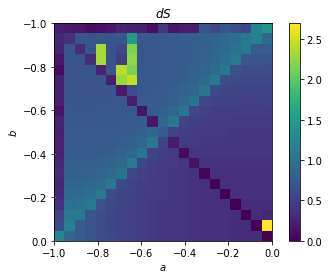

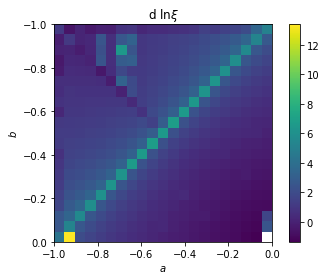

In [89]:
prefix = 'data/comb/'
chi1 = 32
chi2 = 64

A, B = np.meshgrid(a_list, b_list)
C1 = np.zeros_like(A)
C2 = np.zeros_like(A)
D1 = np.zeros_like(A)
D2 = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a = A[i, j]
        b = B[i, j]
        
        
        Jx, Jy, Jz = get_xyz(a, b, biased=False)
#         print(f'Load the data of Jx={Jx}, Jy={Jy}, Jz={Jz}, L={L}, chi={chi1}')
#         data = load_data(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi1, prefix=prefix)
#         if data == -1: # not exists
#             C1[i, j] = np.nan
#             D1[i, j] = np.nan
#             pass
#         else:            
#             psi = data['psi']
#             C1[i, j] = np.mean(psi.entanglement_entropy())
#             D1[i, j] = psi.correlation_length()
        
        print(f'Load the data of Jx={Jx}, Jy={Jy}, Jz={Jz}, L={L}, chi={chi2}')
        data = load_data(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi2, prefix=prefix)
        if data == -1: # not exists
            print("Not existing")
            C2[i, j] = np.nan
            D2[i, j] = np.nan
            pass
        else:
            psi = data['psi']
            C2[i, j] = np.mean(psi.entanglement_entropy())
            D2[i, j] = np.log(psi.correlation_length())
        
#         C2[i, j] = xi_dict[(a, b, chi2)]
        
plt.imshow(C2 - C1, extent=[a_list[0], a_list[-1], b_list[0], b_list[-1]], origin='lower',
           cmap='viridis')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"$dS$")
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

plt.imshow(D2 - D1, extent=[a_list[0], a_list[-1], b_list[0], b_list[-1]], origin='lower',
           cmap='viridis')
plt.colorbar()
plt.axis(aspect='image')
plt.title(r"d $\ln\xi$")
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show()

OK the diagram really seems... quite worse than before...

## Finite DMRG

In [97]:
def fDMRG_KL(Jx, Jy, Jz, L, chi=30, verbose=True, order='default', bc_MPS='finite', bc='open'):
    """
        The finite DMRG for Kitaev Ladders
    """
    
    print("finite DMRG, Kitaev ladder model")
    print("L = {L:d}, Jx = {Jx:.2f}, Jy = {Jy:.2f}, Jz = {Jz:.2f}, ".format(L=L, Jx=Jx, Jy=Jy, Jz=Jz))
    model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
    M = KitaevLadderSnakeModel(model_params)
    
    print("bc_MPS = ", M.lat.bc_MPS)
    
    product_state = [np.random.choice(["up", "down"]) for i in range(M.lat.N_sites)]
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
#         'mixer': None,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': chi,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
#     mag_x = np.sum(psi.expectation_value("Sigmax"))
#     mag_z = np.sum(psi.expectation_value("Sigmaz"))
#     print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
#     print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
#     if L < 20:  # compare to exact result
# #         from tfi_exact import finite_gs_energy
#         E_exact = finite_gs_energy(L, 1., g)
#         print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
#         print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M

In [91]:
Jx = 1
Jy = 0.5
Jz = 0.5
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 0.50, Jz = 0.50, 
Reading 'L'=100 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'order'='default' for config KitaevLadderSnakeModel
Reading 'bc'='open' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=0.5 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -57.5169009680381649, S = nan, norm_err = 4.7e-03
Current memory usage 486.0 MB, time elapsed: 268.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7152

sweep 50, age = 400
Energy = -57.5169022050603758, S = 1.4735086620326048, norm_err = 8.5e-04
Current memory usage 486.0 MB, time elapsed: 669.7 s
Delta E = 8.6996e-09, Delta S = 3.0825e-06 (per sweep)
max_trunc_err = 8.2340e-07, max_E_trunc = 1.2880e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 400, maximum chi = 30
E = -57.5169022050604
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

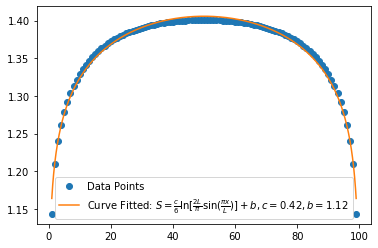

In [92]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [93]:
Jx = 1
Jy = 1
Jz = 0.5
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 1.00, Jz = 0.50, 
Reading 'L'=100 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'order'='default' for config KitaevLadderSnakeModel
Reading 'bc'='open' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -69.9770833153528145, S = nan, norm_err = 4.5e-06
Current memory usage 486.0 MB, time elapsed: 193.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1180e-

DMRG finished after 40 sweeps.
total size = 400, maximum chi = 30
E = -69.9770832872980
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

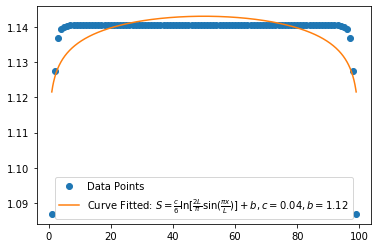

In [94]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [102]:
Jx = 1
Jy = 1
Jz = 0.5
L = 20
chi = 200
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L, chi=chi)

finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 1.00, Jz = 0.50, 
Reading 'L'=20 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'order'='default' for config KitaevLadderSnakeModel
Reading 'bc'='open' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 80
Energy = -13.8636759337861584, S = nan, norm_err = 1.8e-09
Current memory usage 709.0 MB, time elapsed: 216.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5322e-16,

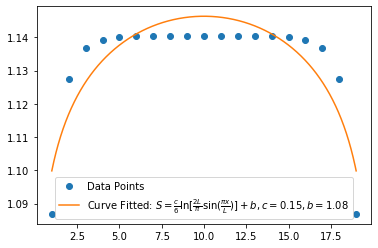

In [103]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

Indeed gapped?

In [104]:
Jx = 1
Jy = 1
Jz = 0.5
L = 2
chi = 100
data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi)
psi = data['psi']

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  100 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


In [105]:
print("EE = ", np.mean(psi.entanglement_entropy()))

EE =  1.6197777067032857


In [106]:
Jx = 1
Jy = 1
Jz = 0.5
L = 2
chi = 200
data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=psi)
psi = data['psi']

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  200 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


In [107]:
Jx = 1
Jy = 1
Jz = 0.5
L = 2
chi = 400
data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi, initial_psi=psi)
psi = data['psi']

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  400 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Conf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


In [110]:
Jx = 1
Jy = -1
Jz = 0.5
L = 50
chi = 30
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L, chi=chi)

finite DMRG, Kitaev ladder model
L = 50, Jx = 1.00, Jy = -1.00, Jz = 0.50, 
Reading 'L'=50 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'order'='default' for config KitaevLadderSnakeModel
Reading 'bc'='open' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=-1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 200
Energy = -34.9062023486284403, S = nan, norm_err = 3.1e-06
Current memory usage 719.8 MB, time elapsed: 135.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0934e-

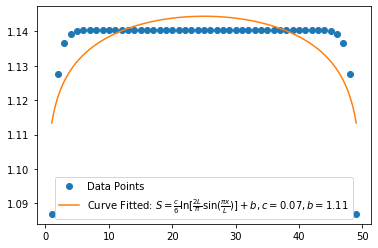

In [113]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [115]:
Jx = 1
Jy = -1
Jz = 0.5
L = 2
chi = 400
data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=chi)
psi = data['psi']

Reading 'L'=2 for config KitaevLadderSnakeModel
Reading 'conserve'=None for config KitaevLadderSnakeModel
Reading 'S'=0.5 for config KitaevLadderSnakeModel
Reading 'bc'='periodic' for config KitaevLadderSnakeModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeModel
Reading 'Jx'=1 for config KitaevLadderSnakeModel
Reading 'Jy'=-1 for config KitaevLadderSnakeModel
Reading 'Jz'=0.5 for config KitaevLadderSnakeModel


==============================START==============================
Chi =  400 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [106, 141, 105, 160, 129, 184, 141, 155]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.07593243926751378-4.83554168928535e-17j)
After the canonicalization:
Bond dim =  [106, 141, 105, 160, 129, 184, 141, 155]
Computing properties
Optimizing
Loop for chi=400 done.
============================== END ==============================
